# Project 2: Housing Prices in Ames, Iowa

## Problem Statement

> My brother has always looked forward to retiring in the future with a career in house flipping. Personally, I do not believe that it is a sustainable option as there are many things to consider when house flipping. House flipping for the uninformed is a way to make "quick cash" through making fast renovations. However, there are many features of a house that impact its final sales price. Using the Ames, Iowa housing data, I will see if there is any one neighborhood or house type that my brother can target to efficiently make a great return on investment. 

## Executive Summary

The data is packed with 80 features of varying types. In order to pick the best features to include in my model, I first had to clean the data. This began with figuring out which columns had null values and deciding what to do with the nulls. To handle the null values, I imputed 'None' for object types and 0 for float or integer data types. After cleaning the data came visualizing the relationship between the different variables and sales price. After choosing the features for my model, I created 3 different models, linear regression, ridge and LASSO. For simplicity, I went with linear regression. 

Unforunately for Iowa, it was also heavily impacted by the 2008 housing market crash. This can be seen by the 48% drop in housing sales from 2009 to 2010 as well as a 4.5% drop in sales prices for the same time frame. As of 2019, Ames, Iowa ranked in the bottom 10 for least positive housing market outlooks [(source)](https://finance.yahoo.com/news/outlook-u-housing-market-hits-153300543.html). However, even with this bleak predicted outlook, there still stands a chance for house flipping and home renovations. THe current housing market is in dire need to new homes to accommodate for the increasing population [(source)](https://www.amestrib.com/news/building-ames-where-housing-market-stands-today). 

### Contents

1. [Data Cleaning](#Data-Cleaning)
2. [EDA I: Preliminary Exploration](#EDA-I:-Preliminary-Exploration)
3. [Preprocessing](#Preprocessing)  
4. [Modeling](#Model)  
5. [Ridge VS Lasso](#Ridge-VS-Lasso)  
6. [Metrics](#Metrics)
7. [Submission](#Kaggle-Submission)  
8. [EDA II: Further Exploration](#EDA-II:-Further-Exploration)  
9. [Conclusion and Recommendations](#Conclusion-and-Recommendations)

## Import packages

In [1425]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import power_transform, StandardScaler, PolynomialFeatures


In [1426]:
df_train = pd.read_csv("./datasets/train.csv")
df_test = pd.read_csv("./datasets/test.csv")

In [1427]:
# Change display options to 80 columns to view all cols
pd.options.display.max_columns = 80

## Data Cleaning

In [1428]:
# Changing the row index to ID
df_train.set_index('Id', inplace = True)
df_test.set_index('Id', inplace = True)

In [1429]:
# Checking for columns with null values
df_train.columns[df_train.isna().any()].tolist()

['Lot Frontage',
 'Alley',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Fence',
 'Misc Feature']

In [1430]:
# Function to change all NaN values in NUMERIC columns to 0
def nan_to_zer(df, list_of_cols):
    for lis in list_of_cols:
        
        # Exclude nulls and check type to see if float or int
        if df[df[lis].notnull()][lis].dtype == 'float64' or df[df[lis].notnull()][lis].dtype == 'int':
            df[lis].fillna(0, inplace = True)   

In [1431]:
# Apply function to training data set 
nan_to_zer(df_train, ['Lot Frontage',
 'Alley',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Fence',
 'Misc Feature'])

In [1432]:
# Apply function to test set to match training and remove nulls in test data 
nan_to_zer(df_test, ['Lot Frontage',
 'Alley',
 'Mas Vnr Type',
 'Mas Vnr Area',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin SF 1',
 'BsmtFin Type 2',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Fireplace Qu',
 'Garage Type',
 'Garage Yr Blt',
 'Garage Finish',
 'Garage Cars',
 'Garage Area',
 'Garage Qual',
 'Garage Cond',
 'Pool QC',
 'Fence',
 'Misc Feature'])

In [1433]:
# Identify values that do not align/make logical sense
# 2261 garage is built in the future at 2207
# Assume that garage was built in 2007
df_train.sort_values('Garage Yr Blt', ascending = False)[['Garage Yr Blt']].head(1)

Garage Yr Blt
Id                 
2261         2207.0

In [1434]:
# Updating value for 2261 garage built year to 2007 from 2207
df_train.loc[2261, ['Garage Yr Blt']] = 2007

In [1435]:
# Check for outliers in lot area
df_train.sort_values('Lot Area', ascending = False)[['Lot Area']].head()

Lot Area
Id            
2116    159000
2072    115149
2767     70761
1499     63887
315      57200

In [1436]:
# Check for outliers in 1st floor square footage
df_train.sort_values('1st Flr SF', ascending = False)[['Gr Liv Area', '1st Flr SF']].head()

Gr Liv Area  1st Flr SF
Id                           
2181         5095        5095
1499         5642        4692
1498         3820        3820
1773         3228        3228
1573         2898        2898

In [1437]:
# Exclude outliers from data for modeling purposes

df_train = df_train[df_train['Gr Liv Area'] < 5_000]
df_train = df_train[df_train['Lot Area'] < 100_000]

In [1438]:
# Return just the columns with null values and number of nulls
nulls = df_train.isnull().sum()
nulls = nulls[nulls > 0]
nulls

Alley             1907
Mas Vnr Type        22
Bsmt Qual           55
Bsmt Cond           55
Bsmt Exposure       58
BsmtFin Type 1      55
BsmtFin Type 2      56
Fireplace Qu      1000
Garage Type        113
Garage Finish      114
Garage Qual        114
Garage Cond        114
Pool QC           2039
Fence             1647
Misc Feature      1984
dtype: int64

In [1439]:
# Null values for test data set
nulls_test = df_test.isnull().sum()

# The data set with null values that are greater than 0
nulls_test = nulls_test[nulls_test > 0]

_**Inference:**_   
The features that I will not be including in my model will be ones with a large quantity of null values  
_To exclude:_ Alley, Pool QC, Misc Feature, Fence, Fireplace Qu  
For the other features, it will be important to replace the null values with a string in order to plot relationships

In [1440]:
# Create a list of features to exclude to keep track of features to exclude throughout analysis
to_exclude = []
to_exclude.extend(['Alley', 'Pool QC', 'Misc Feature', 'Fence', 'Fireplace Qu'])

In [1441]:
# Set null values in string types to 'None' for modeling purposes and graphing
# IF there is 'None' means the property does not have that related feature
# ie. 'None' in Alley or Bsmt -> no alley, no basement
df_train[nulls.index] = df_train[nulls.index].fillna('None')

In [1442]:
# Apply same logic as above to test dataset
df_test[nulls_test.index] = df_test[nulls_test.index].fillna('None')

In [1443]:
# Return just the columns with 0 values and number of 0s
zeroes = (df_train == 0).sum()
zeroes = zeroes[zeroes > 0]
zeroes

Lot Frontage        328
Mas Vnr Area       1238
BsmtFin SF 1        658
BsmtFin SF 2       1800
Bsmt Unf SF         166
Total Bsmt SF        55
2nd Flr SF         1189
Low Qual Fin SF    2014
Bsmt Full Bath     1201
Bsmt Half Bath     1923
Full Bath             8
Half Bath          1306
Bedroom AbvGr         5
Kitchen AbvGr         2
Fireplaces         1000
Garage Yr Blt       114
Garage Cars         114
Garage Area         114
Wood Deck SF       1074
Open Porch SF       912
Enclosed Porch     1720
3Ssn Porch         2021
Screen Porch       1866
Pool Area          2039
Misc Val           1984
dtype: int64

## EDA I: Preliminary Exploration

In [1444]:
# Plotting functions to be used throughout for analysis

# Function for plotting multiple scatter plots
# Set default of y variable to Sale Price

def subplot_scatter(dataframe, list_of_columns, list_of_titles, y = 'SalePrice'):
    nrows = int(np.ceil(len(list_of_columns)/2))         
    fig, ax = plt.subplots(nrows, ncols=2, figsize = (15,15))        
    ax = ax.ravel()                           
    for i, column in enumerate(list_of_columns):        
        sns.scatterplot(x = dataframe[column], y = dataframe[y], data = dataframe,
                       ax = ax[i])                   
        ax[i].set_title(list_of_titles[i])                               
    plt.subplots_adjust(top = 3, wspace = 0.5, hspace = .5)

    
# Function to plot multiple histograms 
def plot_dist(dataframe, list_of_columns, list_of_titles):
    nrows = int(np.ceil(len(list_of_columns)/2))         
    fig, ax = plt.subplots(nrows, ncols=2, figsize = (10,10))        
    ax = ax.ravel()                           
    for i, column in enumerate(list_of_columns):        
        ax[i].hist(dataframe[column])           
        ax[i].set_title(list_of_titles[i])                               
    plt.subplots_adjust(top = 3, wspace = 0.5, hspace = .5)
    
    
# Function to plot multiple box plots
def plot_box(dataframe, list_of_columns, list_of_titles):
    nrows = int(np.ceil(len(list_of_columns)/2))         
    fig, ax = plt.subplots(nrows, ncols=2, figsize = (15,20))        
    ax = ax.ravel()                           
    for i, column in enumerate(list_of_columns):        
        sns.boxplot(x = dataframe[column], y = dataframe['SalePrice'], ax = ax[i])            
        ax[i].set_title(list_of_titles[i])                               
    plt.subplots_adjust(top = 3, wspace = 0.5, hspace = .5)

# Function will plot just ONE sns scatterplot with the y variable always set to price 
def scatterp(x,ax, y = 'SalePrice', d = df_train):
    return sns.scatterplot(x = x, y = y, data = d, ax= ax)

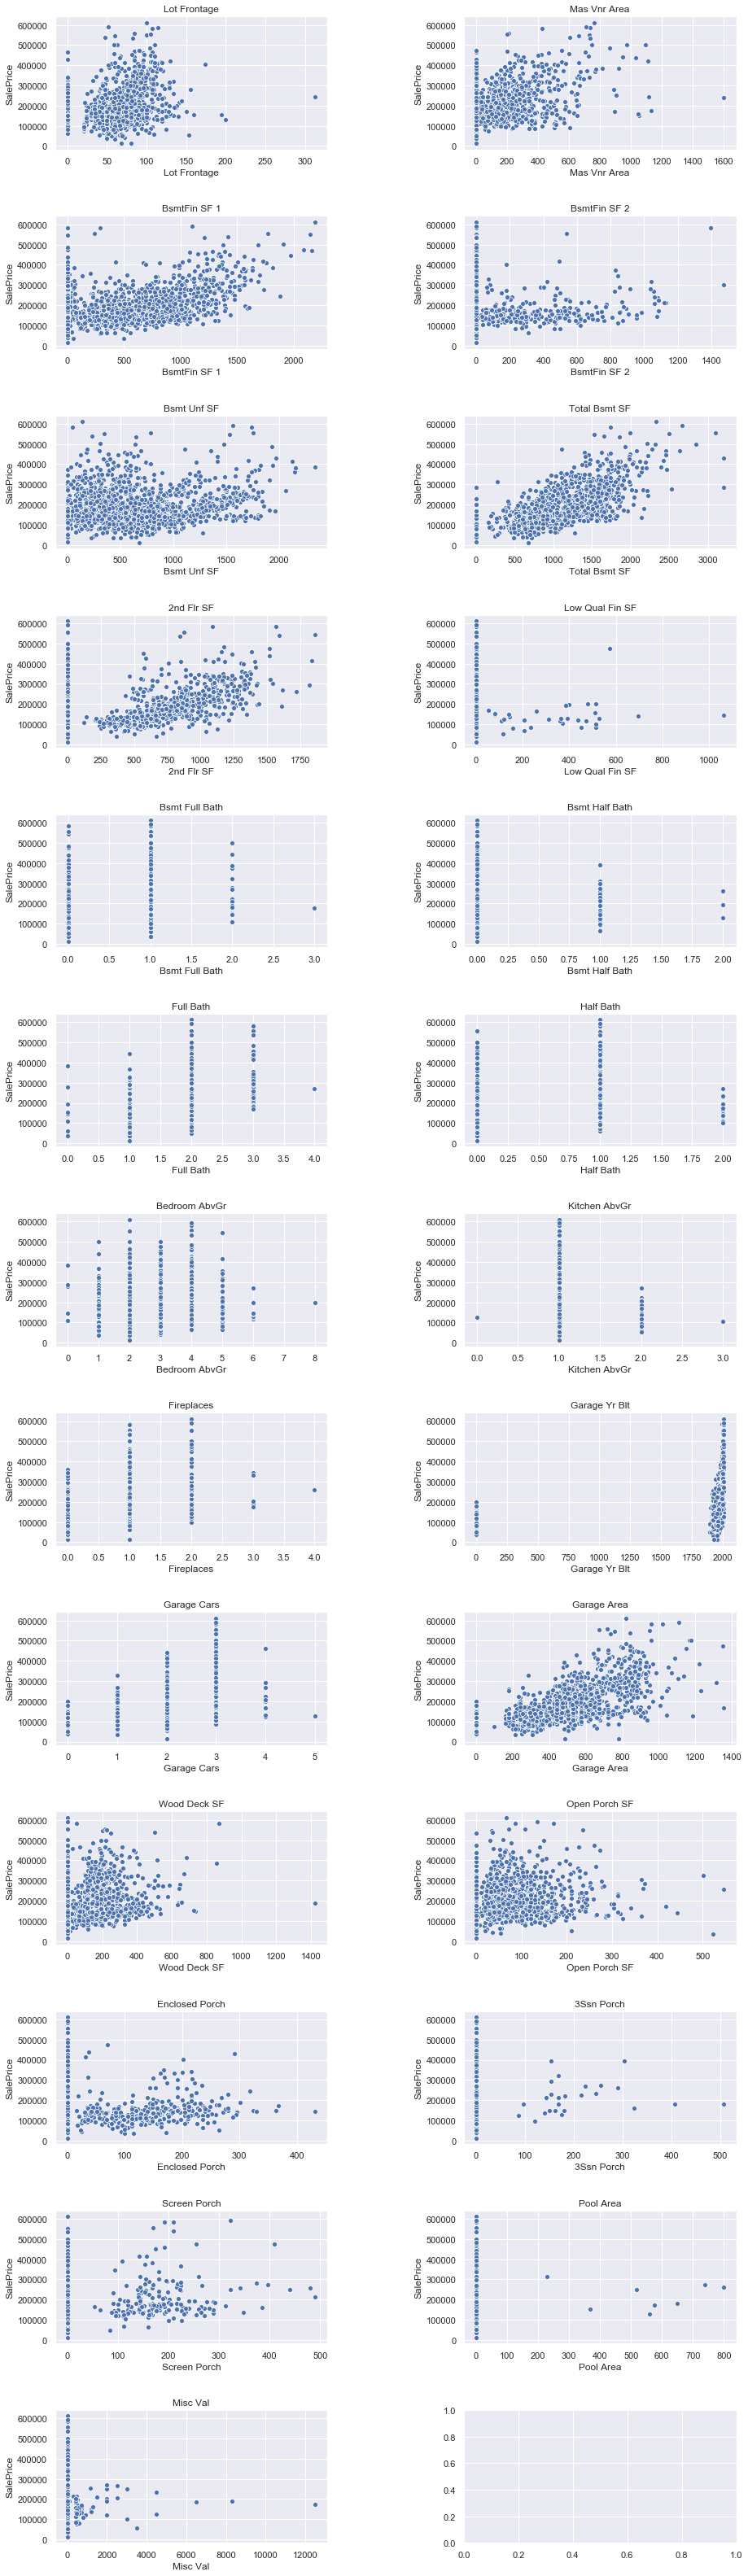

In [1445]:
# Plot the relationship between sale price and columns with zero values in order to visualize which features 
# will remain relevant to the model
subplot_scatter(df_train, 
               zeroes.index,
               zeroes.index)

_**Inference:**_  
Excluding features that have a lot of 0's and a non linear relationship   
_To exclude:_ BsmntFin SF 2, Bsmt Unf SF, Low Qual Fin SF, Garage Yr Blt, 35sn Porch, Pool Area, Screen Porch, Misc Val  
All other values will need further analysis before conclusively excluding as a feature

In [1446]:
# Add the new values to exclude in exclusion list
to_exclude.extend(['BsmtFin SF 2', 'Bsmt Unf SF', 'Low Qual Fin SF', 'Garage Yr Blt', '3Ssn Porch', 'Pool Area', 
                   'Screen Porch', 'Misc Val'])

In [1447]:
# Create lists of different data types for plotting purposes

# Create a list of integer type column names
int_types = df_train.dtypes == 'int'
int_types = int_types[int_types == True].index


# Create a list of float type column names
float_types = df_train.dtypes == 'float'
float_types = float_types[float_types == True].index


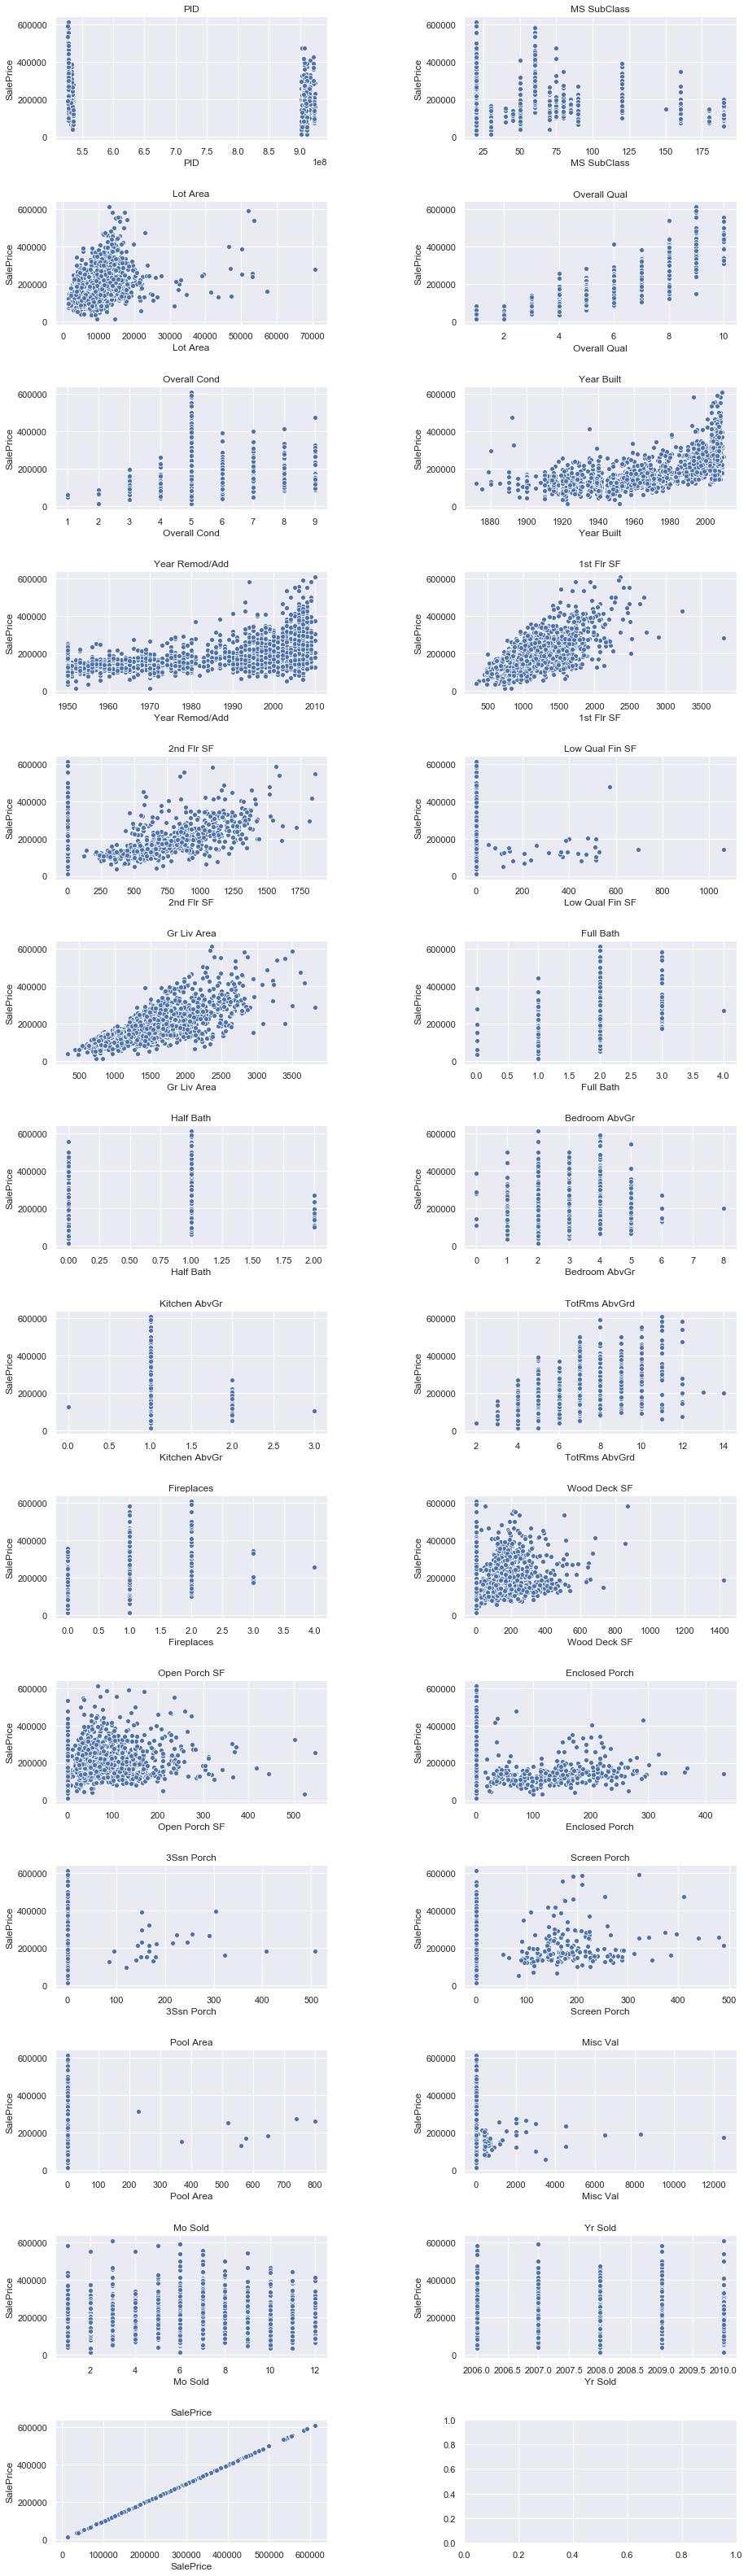

In [1448]:
# Plotting price vs integer values
subplot_scatter(df_train, 
               int_types,
               int_types)

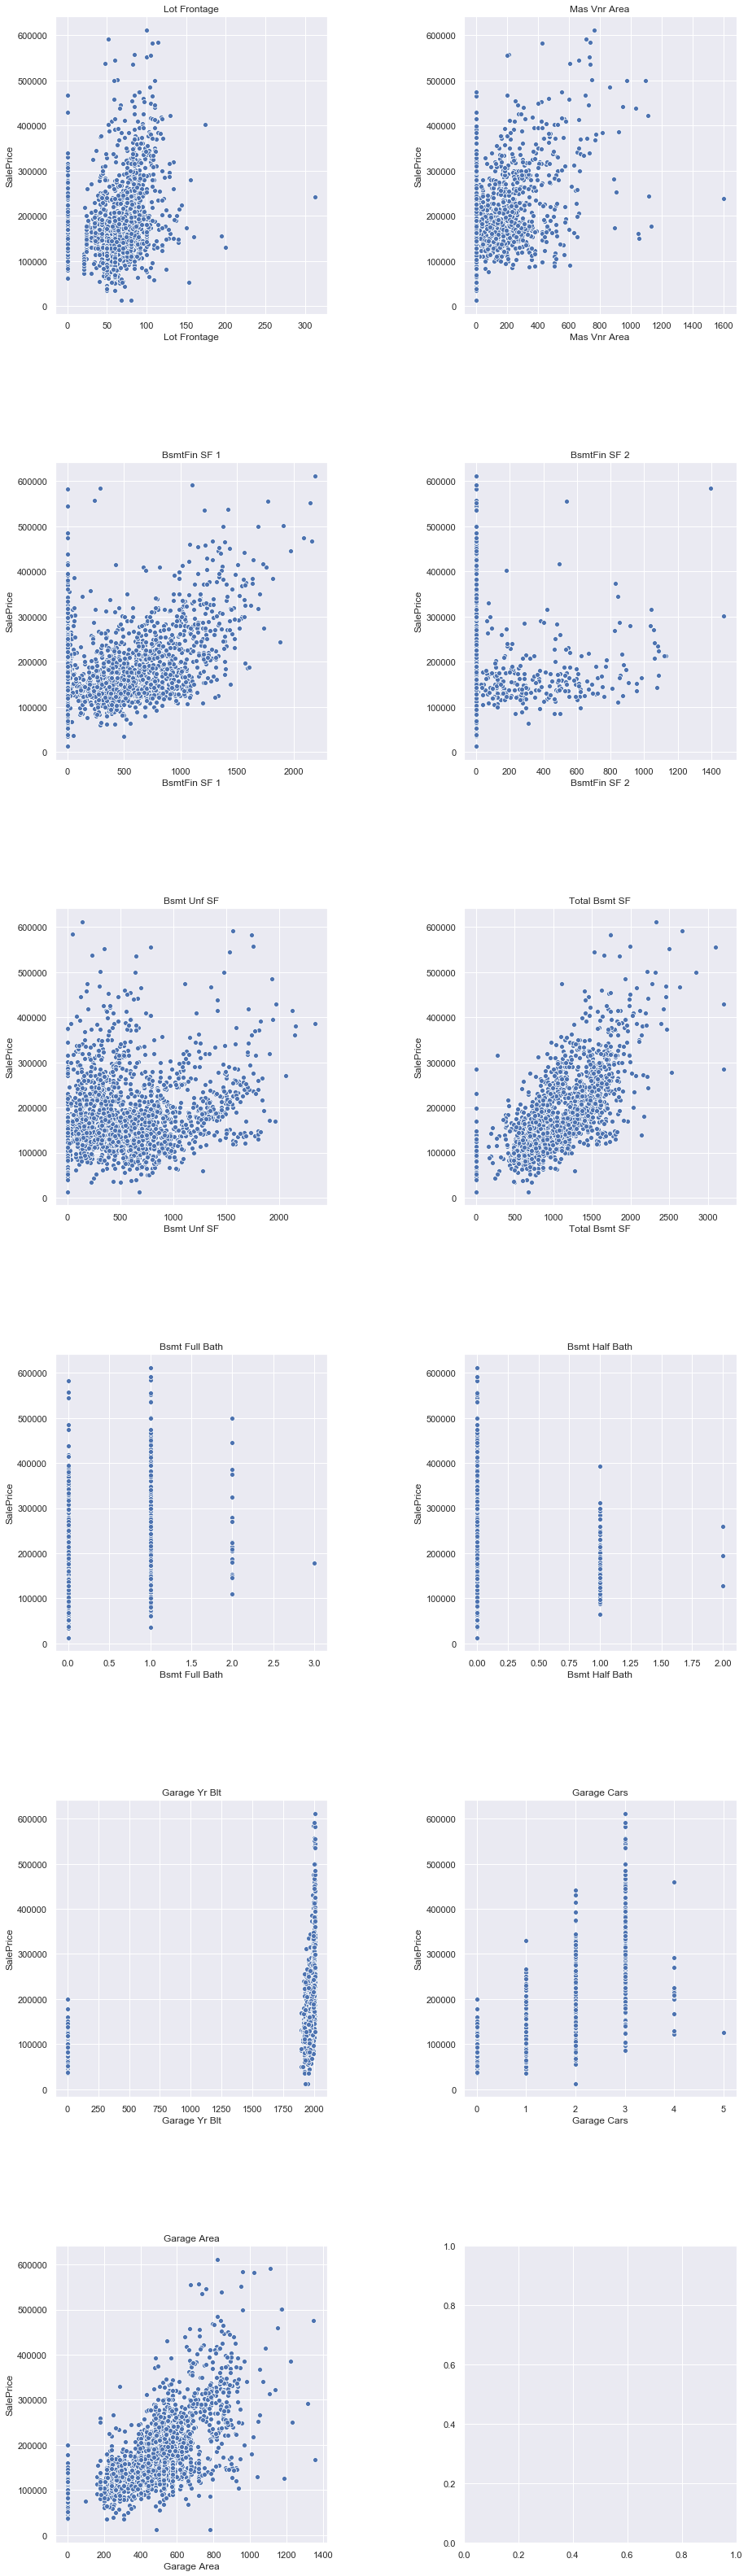

In [1449]:
# Plotting price vs float values
subplot_scatter(df_train, 
               float_types,
               float_types)

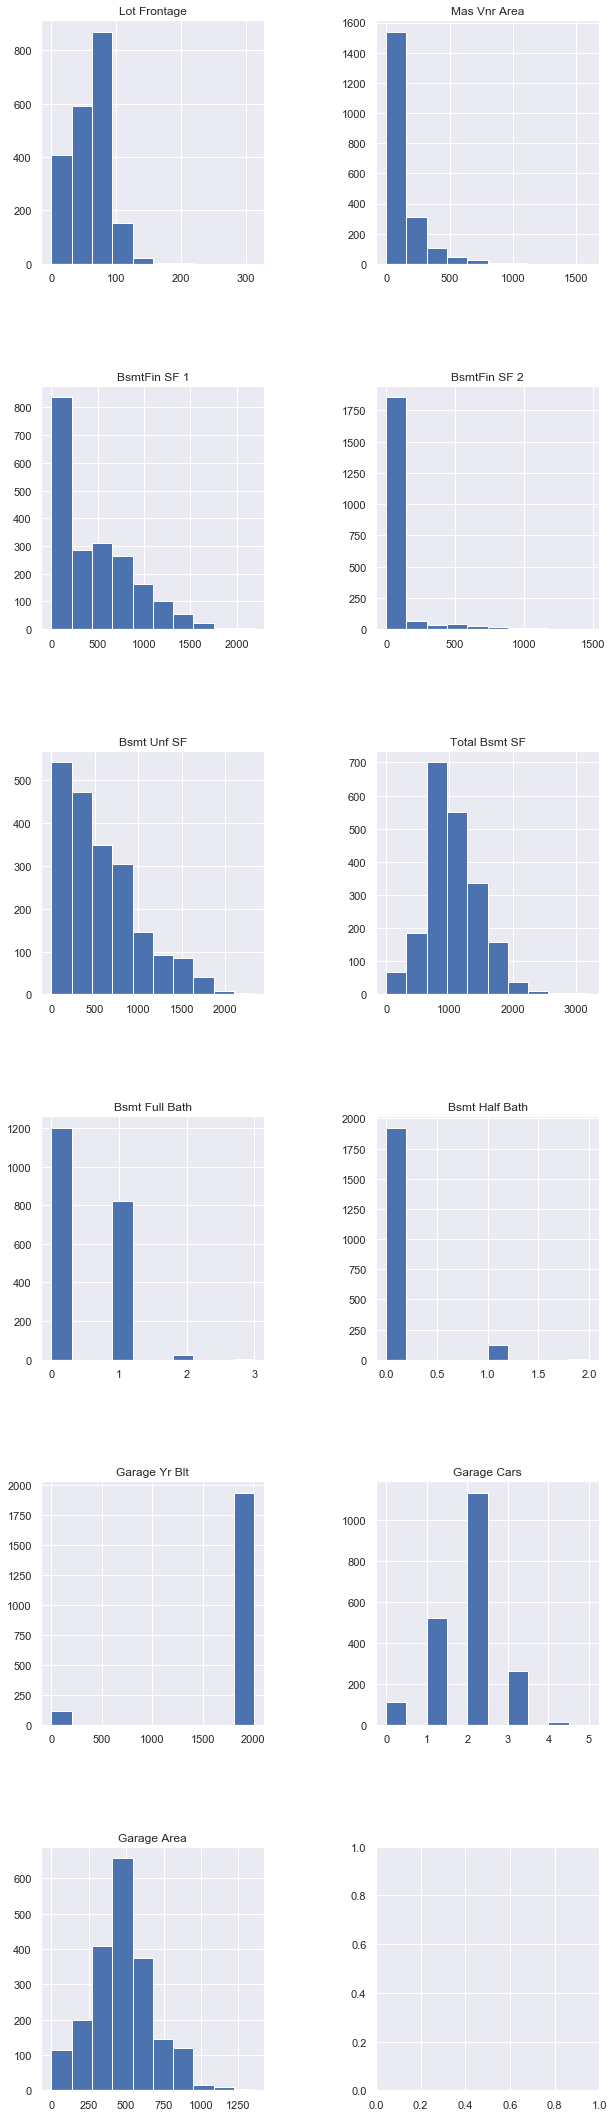

In [1450]:
# Plot histogram for float types to check for normal distribution or see if there are any features to change
plot_dist(df_train, float_types, float_types)

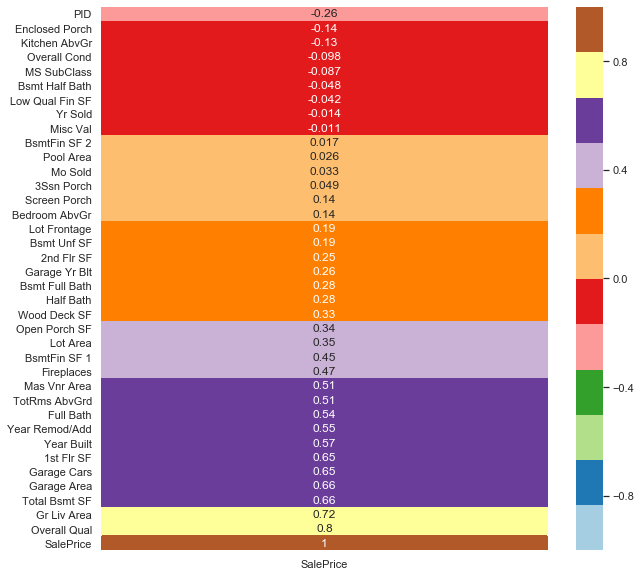

In [1451]:
# Heat map of correlations to saleprice
fig, ax = plt.subplots(figsize = (10,10))

sns.heatmap(df_train.corr()[['SalePrice']].sort_values('SalePrice'), cmap = 'Paired', vmin= -1, ax = ax, annot= True)

In [1452]:
# Check to see which correlations stand out with a filter since heatmap is very large
# Interesting values > .5 or < -.5
corr_saleprice = df_train.corr()['SalePrice']
corr_saleprice[(corr_saleprice > .5) | (corr_saleprice < -.5)]

Overall Qual      0.803859
Year Built        0.573244
Year Remod/Add    0.550378
Mas Vnr Area      0.510228
Total Bsmt SF     0.664607
1st Flr SF        0.647680
Gr Liv Area       0.719230
Full Bath         0.537850
TotRms AbvGrd     0.510838
Garage Cars       0.648459
Garage Area       0.655278
SalePrice         1.000000
Name: SalePrice, dtype: float64

In [1453]:
# Include the above features to our model because of higher correlation to sale price
features = []
features.extend(['Overall Qual', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Full Bath',
       'TotRms AbvGrd', 'Garage Cars', 'Garage Area', 'SalePrice'])

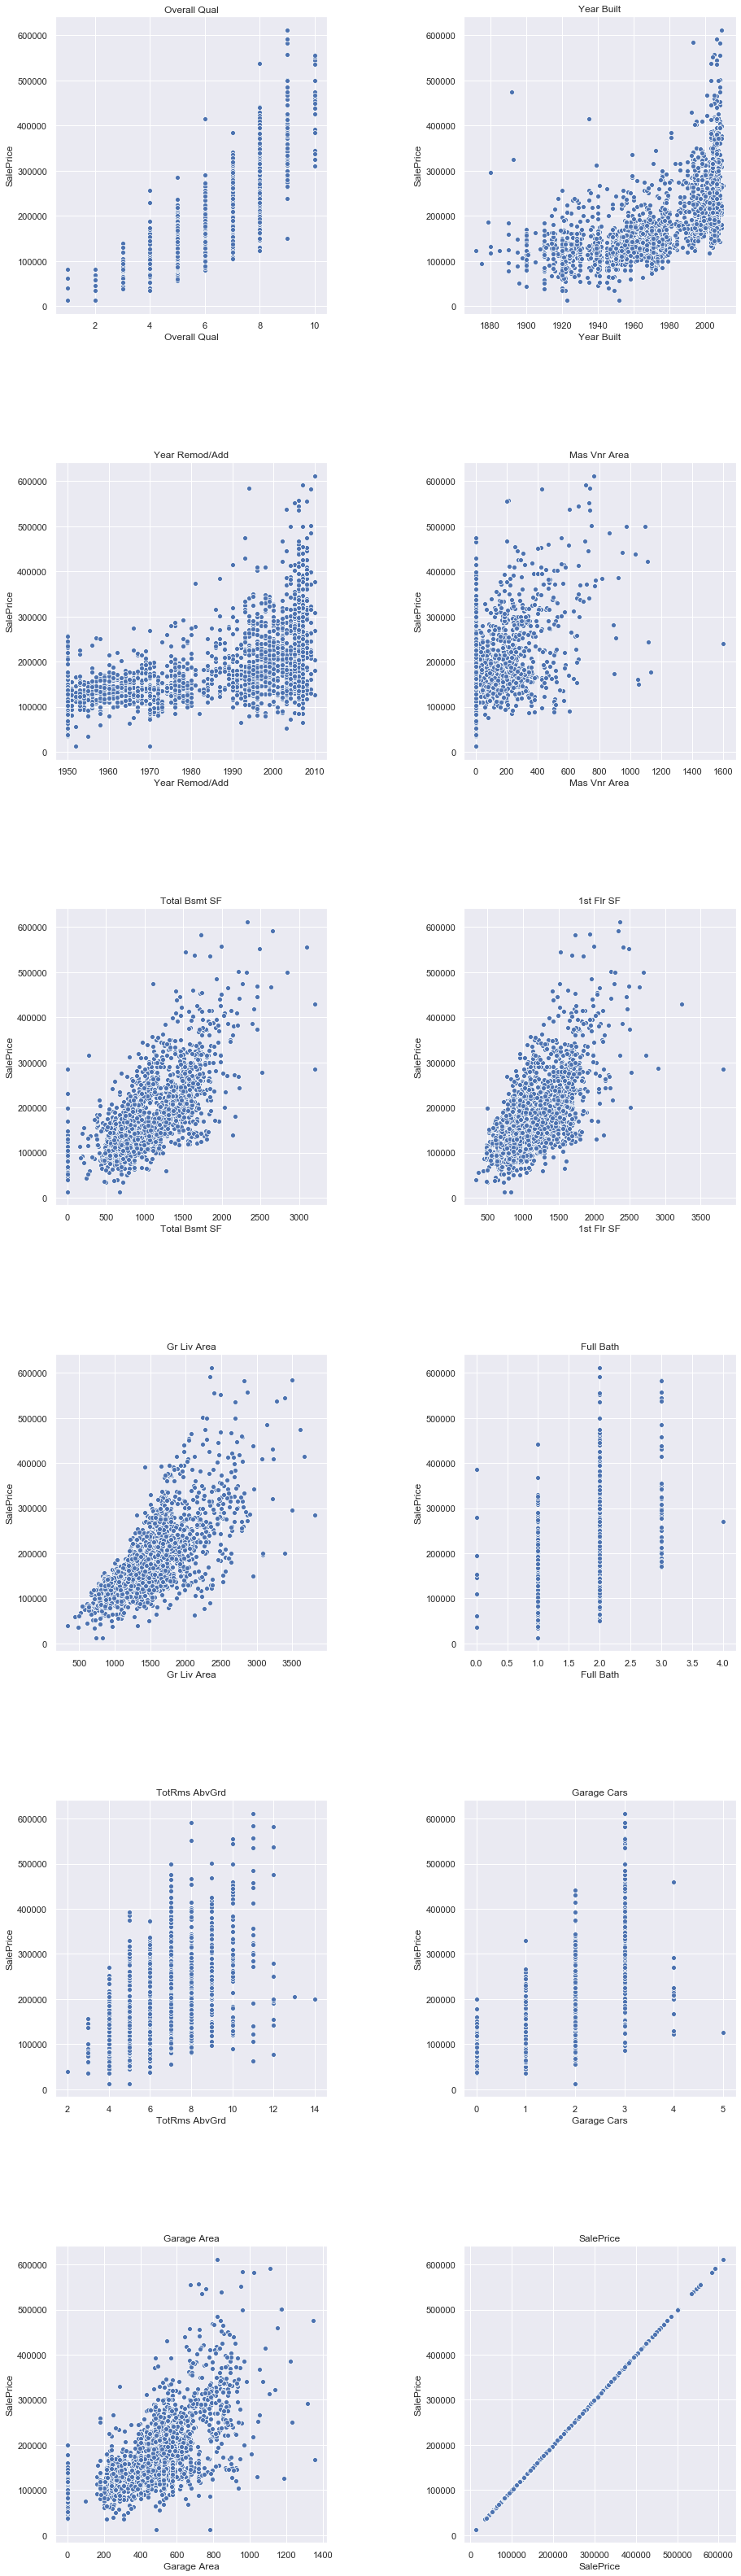

In [1454]:
# Plot the relationship to price visualize and check to see that the features make sense to include in model
subplot_scatter(df_train, features, features)

In [1455]:
# Function to plot scatter plots and histograms together
def sct_dst_subplot(df, col):
    fig, ax = plt.subplots(1,2)
    scatterp(x = df[col], ax = ax[0])
    sns.distplot(df[col], ax = ax[1])
    plt.subplots_adjust(wspace = 0.5)

In [1456]:
# Return the features that have not yet been excluded
remaining_features = df_train.drop(to_exclude, axis = 1).head().columns

In [1457]:
# Returns just the numerical columns
def return_num(df, list_of_cols):
    num_list = []
    for lis in list_of_cols:
        
        # Exclude nulls and check type to see if float or int
        if df[lis].dtype == 'float64' or df[lis].dtype == 'int':
            num_list.append(lis) 
    return num_list

In [1458]:
# Returning numerical columns for data from the remaining features that have not yet been sorted 
num_remaining = return_num(df_train, remaining_features)

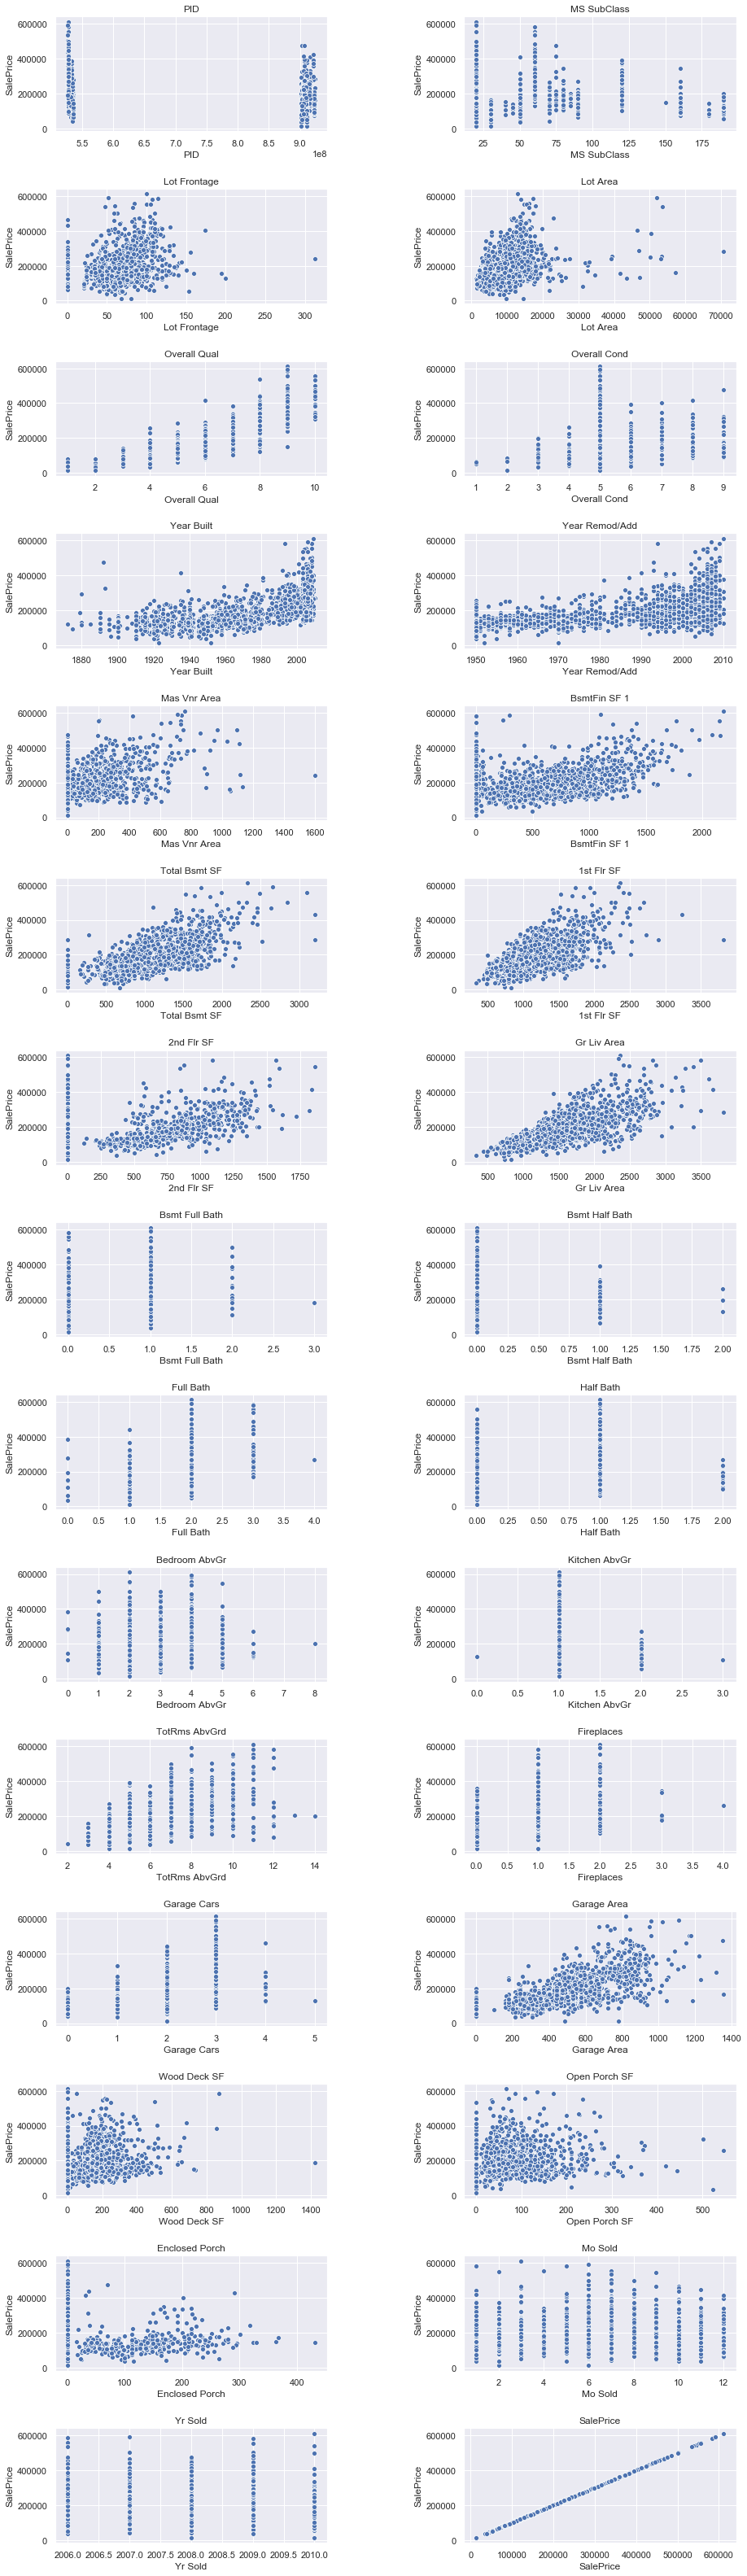

In [1459]:
# Plotting numerical columns that are not part of the excluded group
subplot_scatter(df_train, num_remaining, num_remaining)


_**Inference:**_  
Based on the graphs above, I will exclude:  
Mo Sold, Yr Sold, Fireplaces, Bedroom AbvGr, Kitchen AbvGr, Bsmt Half Bath, Half Bath, Bsmt Full Bath, PID   

Features that are interesting: 
Lot Frontage, Lot Area, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Total Bsmt SF, 1st Flr SF, 2nd Flr SF, Gr Liv Area, Full Bath, TotRms AbvGrd, Garage Cars, Garage Area, Enclosed Porch

In [1460]:
to_exclude.extend(['Mo Sold', 'Yr Sold', 'Fireplaces', 'Bedroom AbvGr', 
                   'Kitchen AbvGr', 'Bsmt Half Bath', 'Half Bath', 'Bsmt Full Bath', 'PID'])


In [1461]:
interesting = ['Lot Frontage', 'Lot Area', 'Overall Qual', 
               'Overall Cond', 'Year Built', 'Year Remod/Add', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 
               'Gr Liv Area', 'Full Bath', 'TotRms AbvGrd', 'Garage Area', 'Enclosed Porch']

In [1462]:
# Appending the columns that were interesting (will have an impact on model) to features list 
# Will check to see if it is already part of the features list and if not, add to features
for feature in interesting: 
    if not feature in features: 
        features.append(feature)

In [1463]:
# Check which features are now remaining 
# Should be just the remaining categorical/object types
obj_remaining = []
for feature in remaining_features: 
    if not feature in num_remaining: 
        obj_remaining.append(feature)

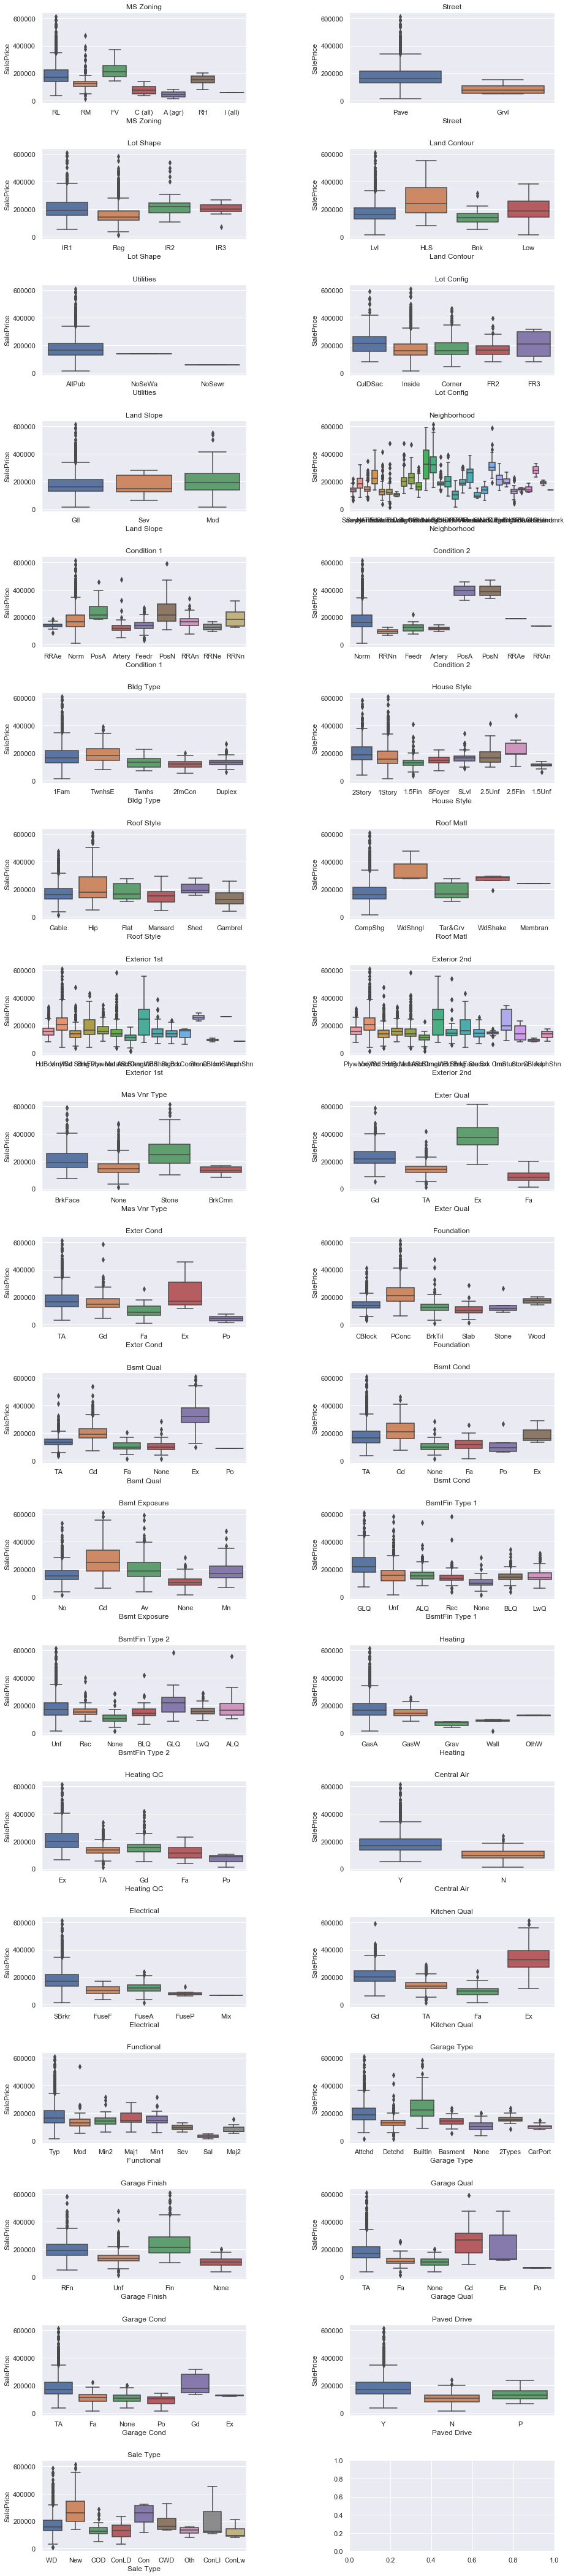

In [1464]:
plot_box(df_train, obj_remaining, obj_remaining)

_**Inference:**_  
From the above box plots, we can see the effect of different qualitative characteristics on sale price.   
TO include in model: Paved Drive, Functional, Kitchen Qual, Electrical, Heating QC, Central Air, Heating, Bsmt Cond, Bsmt Qual, Exter Cond, Foundation, Neighborhood, MS Zoning, Street

In [1465]:
features.extend(['Street', 'MS Zoning', 'Utilities', 'Neighborhood', 
                 'Roof Style', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 
                'BsmtFin Type 1', 'Heating', 'Heating QC', 'Central Air','Electrical', 
                'Kitchen Qual', 'Functional', 'Garage Type', 'Paved Drive', 'Lot Shape', 'Bldg Type', 'Land Contour', 
                'MS SubClass', 'House Style', 'Land Slope', 'Condition 1', 'Bldg Type', 'Exter Cond'])

## Feature Engineering

In [1466]:
# Code from https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
# See which columns have high correlations and create interaction terms from the results

corr_matrix = df_train.drop('SalePrice', axis = 1).corr().abs()

# Masking bottom half of the correlation matrix 
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


high_corr = [column for column in upper.columns if any(upper[column] > 0.7)]

In [1467]:
high_corr

['1st Flr SF', 'TotRms AbvGrd', 'Garage Area']

**Inference:** 
- High correlation between garage area and garage cars (which makes sense)  
- 1st Flr SF and Total Bsmt SF (also makes sense) 
- TotRms AbvGrd and Gr Liv Area (interesting)

In [1468]:
# Create interaction terms from high correlation variables 
df_train['Garage_interaction'] = df_train['Garage Area'] * df_train['Garage Cars']
df_train['Flr_interaction'] = df_train['1st Flr SF'] * df_train['Total Bsmt SF']
df_train['Rms_interaction'] = df_train['TotRms AbvGrd'] * df_train['Gr Liv Area']

In [1469]:
# Add garage interaction to features as it seems to be the most dependent on one another
features.append('Garage_interaction')

In [1475]:
# Remove the 2 variables that make up the interaction term from the features
features.remove('Garage Cars')
features.remove('Garage Area')

_Dummy variables were created during the preprocessing phase in order to include all variables into model_

## Preprocessing

In [1480]:
# At some poitn SalePrice gets included in the features; remove from features
features.remove('SalePrice')

In [1491]:
# Get just the unique values of the features in case duplicates were added at some point 
features = set(features)

In [1151]:
# Set X and y for modeling
X = df_train[features]
y = df_train['SalePrice']

In [1152]:
X.head()

Year Built  Year Remod/Add  Mas Vnr Area  Full Bath  Lot Frontage  \
Id                                                                       
109        1976            2005         289.0          2           0.0   
544        1996            1997         132.0          2          43.0   
153        1953            2007           0.0          1          68.0   
318        2006            2007           0.0          2          73.0   
255        1900            1993           0.0          2          82.0   

     Lot Area  2nd Flr SF  Enclosed Porch Street MS Zoning Utilities  \
Id                                                                     
109     13517         754               0   Pave        RL    AllPub   
544     11492        1209               0   Pave        RL    AllPub   
153      7922           0               0   Pave        RL    AllPub   
318      9802         700               0   Pave        RL    AllPub   
255     14235         614               0   Pave        RL    AllPub   

    Neighborhood Roof Style Foundation Bsmt Qual Bsmt Cond BsmtFin Type 1  \
Id                                                                          
109       Sawyer      Gable     CBlock        TA        TA            GLQ   
544      SawyerW      Gable      PConc        Gd        TA            GLQ   
153        NAmes      Gable     CBlock        TA        TA            GLQ   
318       Timber      Gable      PConc        Gd        TA            Unf   
255      SawyerW      Gable      PConc        Fa        Gd            Unf   

    Heating Heating QC Central Air Electrical Kitchen Qual Functional  \
Id                                                                      
109    GasA         Ex           Y      SBrkr           Gd        Typ   
544    GasA         Ex           Y      SBrkr           Gd        Typ   
153    GasA         TA           Y      SBrkr           Gd        Typ   
318    GasA         Gd           Y      SBrkr           TA        Typ   
255    GasA         TA           Y      SBrkr           TA        Typ   

    Garage Type Paved Drive  Garage_interaction  1st Flr SF  Total Bsmt SF  \
Id                                                                           
109      Attchd           Y               950.0         725          725.0   
544      Attchd           Y              1118.0         913          913.0   
153      Detchd           Y               246.0        1057         1057.0   
318     BuiltIn           Y               800.0         744          384.0   
255      Detchd           N               968.0         831          676.0   

     TotRms AbvGrd  Gr Liv Area  Overall Qual  Overall Cond  MS SubClass  \
Id                                                                         
109              6         1479             6             8           60   
544              8         2122             7             5           60   
153              5         1057             5             7           20   
318              7         1444             5             5           60   
255              6         1445             6             8           50   

    House Style Lot Shape Land Contour Land Slope Condition 1 Bldg Type  \
Id                                                                        
109      2Story       IR1          Lvl        Gtl        RRAe      1Fam   
544      2Story       IR1          Lvl        Gtl        Norm      1Fam   
153      1Story       Reg          Lvl        Gtl        Norm      1Fam   
318      2Story       Reg          Lvl        Gtl        Norm      1Fam   
255      1.5Fin       IR1          Lvl        Gtl        Norm      1Fam   

    Exter Cond  
Id              
109         TA  
544         TA  
153         Gd  
318         TA  
255         TA

In [1153]:
# Convert the categorical columns into processable numbers (turning into dummy variables)
# dummy variable = yes or no
X = pd.get_dummies(X, columns = ['Street', 'MS Zoning', 'Utilities', 'Neighborhood', 
                 'Roof Style', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 
                'BsmtFin Type 1', 'Heating', 'Heating QC', 'Central Air','Electrical', 
                'Kitchen Qual', 'Functional', 'Garage Type', 'Paved Drive',
                'House Style', 'Lot Shape', 'Land Contour', 'Land Slope', 'Condition 1', 'Bldg Type', 'Exter Cond'], 
                   drop_first = True)

In [791]:
X.tail()

Overall Qual  Year Built  Year Remod/Add  Mas Vnr Area  Full Bath  \
Id                                                                        
1587             8        2007            2007           0.0          2   
785              4        1940            1950           0.0          1   
916              6        1928            1950           0.0          1   
639              4        1956            1956           0.0          1   
10               7        1999            1999           0.0          2   

      Lot Frontage  Lot Area  Overall Cond  2nd Flr SF  Enclosed Porch  \
Id                                                                       
1587          79.0     11449             5           0               0   
785            0.0     12342             5           0               0   
916           57.0      7558             6         741               0   
639           80.0     10400             5           0             140   
10            60.0      7500             5         776               0   

      Garage_interaction  1st Flr SF  Total Bsmt SF  TotRms AbvGrd  \
Id                                                                   
1587              1040.0        1728         1884.0              7   
785               1078.0         861          861.0              4   
916                684.0        1172          896.0              9   
639                294.0        1200         1200.0              6   
10                 884.0        1028          994.0              7   

      Gr Liv Area  Street_Pave  MS Zoning_C (all)  MS Zoning_FV  \
Id                                                                
1587         1728            1                  0             0   
785           861            1                  0             0   
916          1913            1                  0             0   
639          1200            1                  0             0   
10           1804            1                  0             0   

      MS Zoning_I (all)  MS Zoning_RH  MS Zoning_RL  MS Zoning_RM  \
Id                                                                  
1587                  0             0             1             0   
785                   0             0             1             0   
916                   0             0             1             0   
639                   0             0             1             0   
10                    0             0             1             0   

      Utilities_NoSeWa  Utilities_NoSewr  Neighborhood_Blueste  \
Id                                                               
1587                 0                 0                     0   
785                  0                 0                     0   
916                  0                 0                     0   
639                  0                 0                     0   
10                   0                 0                     0   

      Neighborhood_BrDale  Neighborhood_BrkSide  Neighborhood_ClearCr  \
Id                                                                      
1587                    0                     0                     0   
785                     0                     0                     0   
916                     0                     0                     0   
639                     0                     0                     0   
10                      0                     0                     0   

      Neighborhood_CollgCr  Neighborhood_Crawfor  Neighborhood_Edwards  \
Id                                                                       
1587                     0                     0                     0   
785                      0                     0                     1   
916                      0                     1                     0   
639                      0                     0                     0   
10                       0                     0                     0   

      Neighborhood_Gil

In [1154]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [1155]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(2047, 140)
(1535, 140)
(512, 140)


In [1000]:
y_train.shape

(1535,)

In [733]:
# Import dummy regressor
from sklearn.dummy           import DummyRegressor

# Instantiate: creates a dummy regression that always predicts the mean of the target
base_mean = DummyRegressor(strategy='mean')

# Fit the "model"
base_mean = base_mean.fit(X_train, y_train)

# Get predictions for our testing set (not kaggle testing set)
y_hat_base_train = base_mean.predict(X_train)
y_hat_base_test = base_mean.predict(X_test)

# Get RMSE
from sklearn.metrics import mean_squared_error
print("Our Train RMSE Score for our Base Model is:",  np.sqrt(mean_squared_error(y_hat_base_train, y_train)))
print("Our Test RMSE Score for our Base Model is:",  np.sqrt(mean_squared_error(y_hat_base_test, y_test)))

Our Train RMSE Score for our Base Model is: 79526.85223710592
Our Test RMSE Score for our Base Model is: 78375.26238032707


## Model

In [1156]:
# Instantiate 
lr = LinearRegression()

# Fit 
our_model = lr.fit(X_train, y_train)

In [1157]:
# Predictions 
y_hat_lr_train = our_model.predict(X_train)
y_hat_lr_test = our_model.predict(X_test)

Our Train RMSE Score for our Base Model is: 22059.6673758462
Our Test RMSE Score for our Base Model is: 23973.592971777274


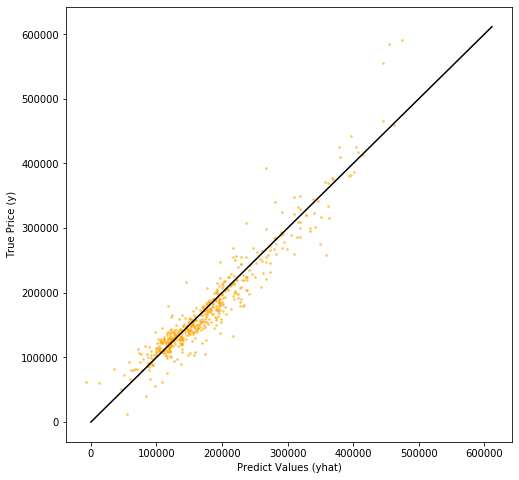

In [1173]:
# Plot the model
plt.figure(figsize=(8,8))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat_lr_test, y_test, alpha = 0.5, s = 3, c = 'orange')
plt.xlabel('Predict Values (yhat)')
plt.ylabel('True Price (y)')

# This makes the 45 degree line
plt.plot([0, np.max(y)], [0, np.max(y)], c='k');

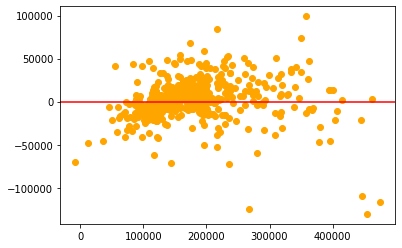

In [1176]:
# Residual plot
residuals = y_hat_lr_test - y_test
plt.scatter(y_hat_lr_test, residuals, c = 'orange')
plt.axhline(0, color = 'red')

## Ridge VS Lasso

In [1160]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))
lasso = LassoCV(n_alphas=200)

ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [1495]:
# Testing lasso
lasso.fit(X_train_sc, y_train)
pred_l = lasso.predict(X_test_sc)
lasso.score(X_train_sc, y_train)

/Applications/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.9180156825530581

In [1496]:
# Lasso on test data
lasso.score(X_test_sc, y_test)

0.9065005952688987

In [1164]:
# Ridge
ridge.fit(X_train_sc, y_train) 
pred = ridge.predict(X_test_sc)

In [1165]:
ridge.score(X_train_sc, y_train)

0.9228168174340493

In [1166]:
# Ridge on testing data
ridge.score(X_test_sc, y_test)

0.9066350944859862

**Infereence:** Ridge performed better on this data set

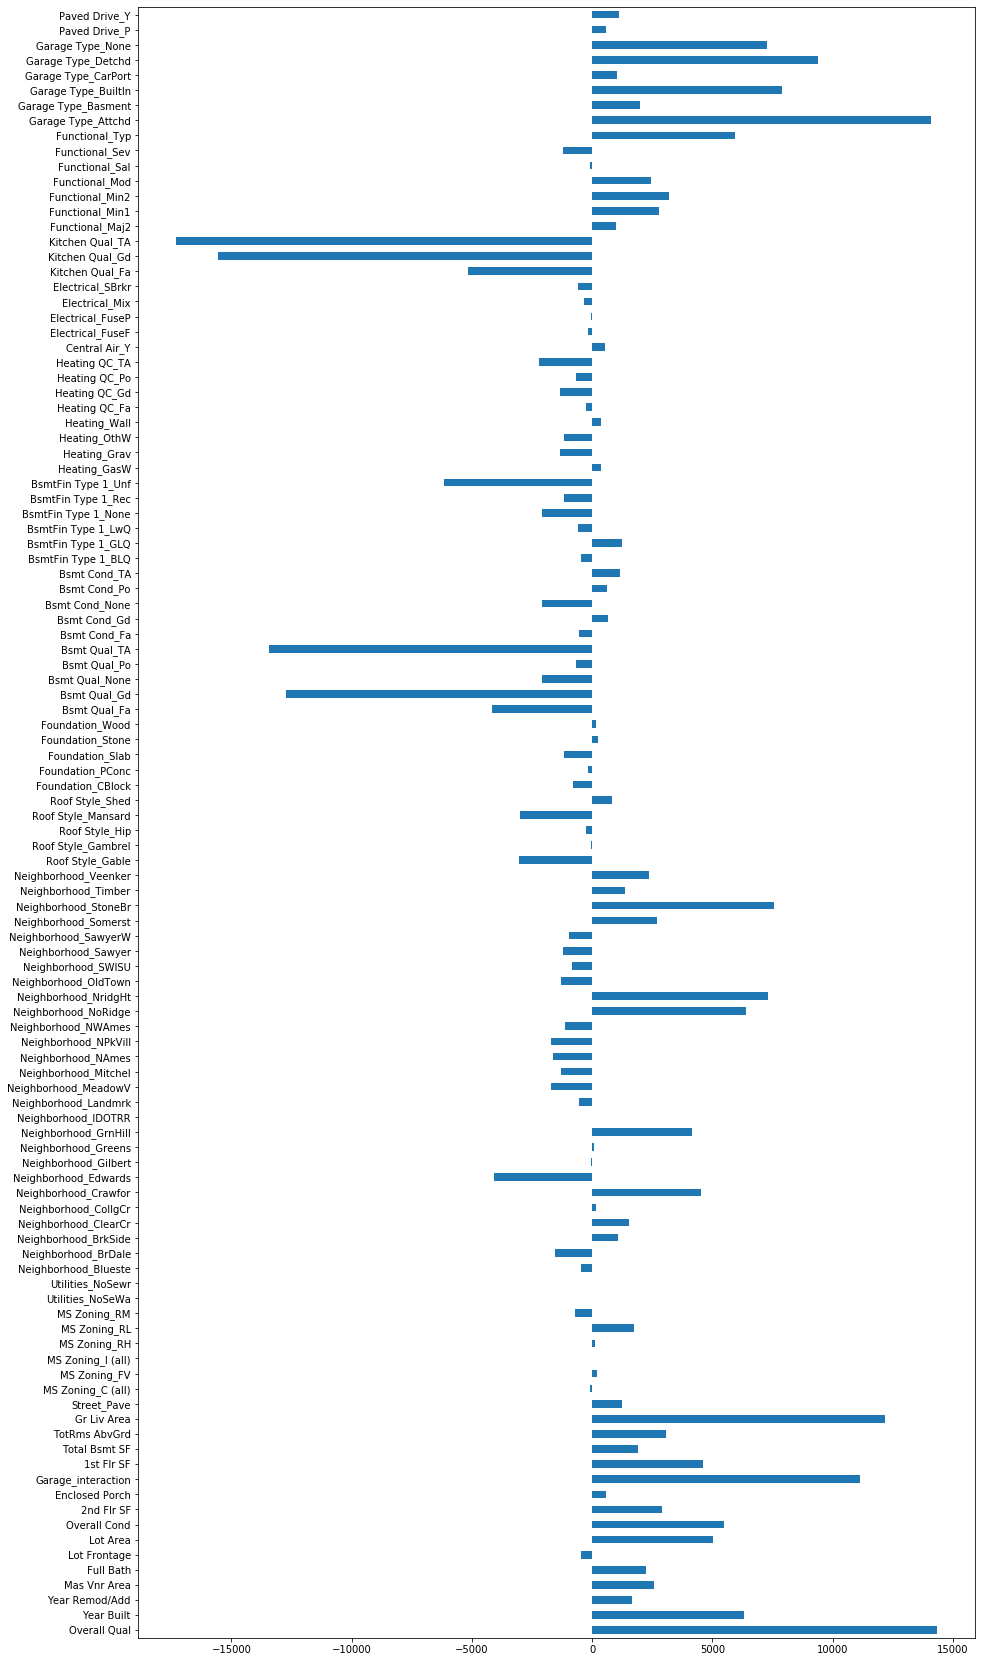

In [804]:
pd.Series(ridge.coef_, index=X.columns).plot.barh(figsize=(15, 30))

## Metrics

In [637]:
# Function to return metrics from model
def metrics_a(y, y_pred):
    MSE = np.round(metrics.mean_squared_error(y_pred, y), 2)
    RMSE = np.round(MSE ** (1/2),2)
    MAE = np.round(metrics.mean_absolute_error(y, y_pred), 2)
    R2 = np.round(metrics.r2_score(y,y_pred), 2)
    SSE = np.round(((y_pred - y.mean())**2).sum(),2)
    RSS = np.round(((y - y_pred) ** 2).sum(),2)
    return "MSE: "+ str(MSE), "RMSE: "+ str(RMSE), "MAE: "+ str(MAE), "R2 :"+ str(R2), "SSE: " + str(SSE), "RSS: "+ str(RSS)



In [1355]:
# Metrics for the Linear Regression training data
metrics_a(y_hat_lr_train, y_train)

('MSE: 486628924.73',
 'RMSE: 22059.67',
 'MAE: 14953.54',
 'R2 :0.92',
 'SSE: 9698867224943.2',
 'RSS: 746975399465.11')

In [1354]:
# Metrics for the Linear Regression testing data
metrics_a(y_hat_lr_test, y_test)

('MSE: 574733159.98',
 'RMSE: 23973.59',
 'MAE: 16505.2',
 'R2 :0.9',
 'SSE: 3141107641017.41',
 'RSS: 294263377907.94')

In [1493]:
# LASSO Prediction metrics
metrics_a(y_test, pred_l)

('MSE: 573153859.85',
 'RMSE: 23940.63',
 'MAE: 16419.3',
 'R2 :0.91',
 'SSE: 2835202205908.06',
 'RSS: 293454776242.43')

In [1494]:
# Ridge prediction metrics
metrics_a(y_test, pred)

('MSE: 572329376.04',
 'RMSE: 23923.41',
 'MAE: 16430.4',
 'R2 :0.91',
 'SSE: 2959895948054.31',
 'RSS: 293032640531.84')

_While the Ridge model performed the best, while exporting to Kaggle in earlier versions, there were difficulties so I focused on using Linear Regression for simplicity_

## Kaggle Submission

In [848]:
# Reproduce interaction terms in test dataset 
df_test['Garage_interaction']  = df_test['Garage Area'] * df_test['Garage Cars']

In [1169]:
X_kaggle = df_test[features]

# Need to apply all feature engineering that I did to my df_train to my df_test as well
# Otherwise model won't get the inputs in the form that it expects

X_kaggle = pd.get_dummies(X_kaggle, columns = ['Street', 'MS Zoning', 'Utilities', 'Neighborhood', 
                 'Roof Style', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 
                'BsmtFin Type 1', 'Heating', 'Heating QC', 'Central Air','Electrical', 
                'Kitchen Qual', 'Functional', 'Garage Type', 'Paved Drive',
                'House Style', 'Lot Shape', 'Land Contour', 'Land Slope', 'Condition 1', 'Bldg Type', 'Exter Cond'],
                          drop_first = True)


In [1170]:
# Code modified from 
# https://stackoverflow.com/questions/41335718/keep-same-dummy-variable-in-training-and-testing-data
# Returns missing columns in data set and appends to list 
missing = []
for col in list(X.columns):
    if not col in list(X_kaggle.columns):
        missing.append(col)

# Creates the missing column and sets values to 0
for c in missing:
    X_kaggle[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
X_kaggle = X_kaggle[X.columns]

In [1171]:
X_kaggle['SalePrice'] = our_model.predict(X_kaggle)

In [1172]:
# Cleaning my kaggle submission dataframe to just include ID (row index) and SalePrice prediction 
X_kaggle = X_kaggle[['SalePrice']]
X_kaggle.to_csv("./my_seventh_submission.csv")

## EDA II: Further Exploration

**In order to isolate certain neighborhoods or home types to recommend for targeting, further analysis was needed**

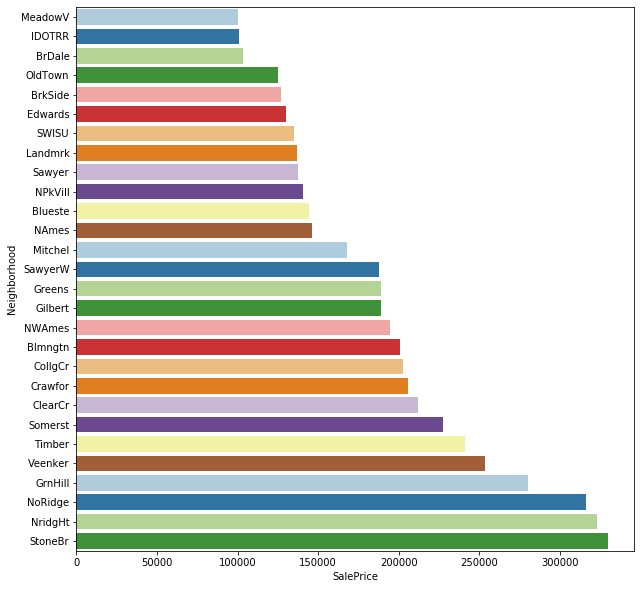

In [1017]:
# Find the average price of sales by neighborhood
hood_price = df_train.groupby(['Neighborhood']).mean()[['SalePrice']].sort_values('SalePrice')


# Bar plot to show different prices for different neighborhoods
fig, ax = plt.subplots(figsize= (10,10))
sns.barplot(x=hood_price['SalePrice'], y=hood_price.index, palette="Paired", ax = ax)

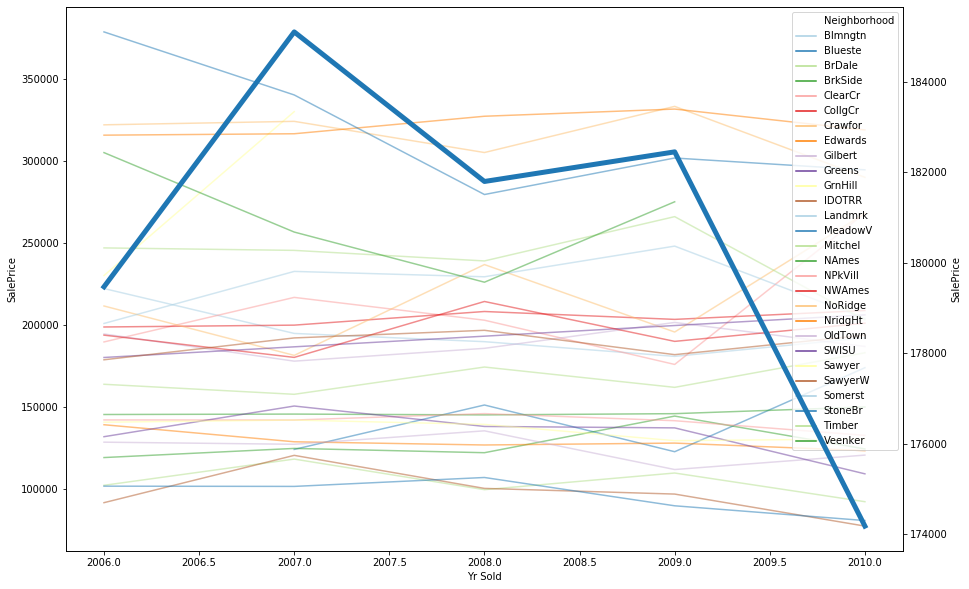

In [1192]:
# Line plot to show average house prices year over year by neighborhood
price_yoy_hood = df_train.groupby(['Neighborhood', 'Yr Sold']).mean()[['SalePrice']]
price_yoy_hood = price_yoy_hood.reset_index()

fig, ax = plt.subplots(figsize= (15,10))
ax2 = ax.twinx()
sns.lineplot(x="Yr Sold", y="SalePrice",
                  hue='Neighborhood',
                  palette = 'Paired',
                  data=price_yoy_hood,
             alpha = 0.5,
            ax = ax)

# Plotting overall average sale prices on top 
sns.lineplot(x=price_year.index, y="SalePrice",
                  palette = 'Paired',
                  data=price_year,
         dashes = True,
             linewidth = 5,
                 ax = ax2)

In [1071]:
# % change YoY in avg housing prices by neighborhood 
price_pivot = price_yoy_hood.pivot(index= 'Neighborhood', columns = 'Yr Sold', values = 'SalePrice') 

4

In [1097]:
# Return % change in price
pct_change = []
for i, row in price_pivot.iterrows():
    pct_change.append(
        
        # Gets the first and last valid number (not null)
        (price_pivot.loc[i, price_pivot.loc[i, :].last_valid_index()] - 
         price_pivot.loc[i, price_pivot.loc[i, :].first_valid_index()])/
        price_pivot.loc[i, price_pivot.loc[i, :].first_valid_index()]
        )

In [1100]:
# New column percent change in price pivot
price_pivot['pct_change'] = pct_change

In [1103]:
# Make the % into more readable format
price_pivot['pct_change'] = price_pivot['pct_change'].apply(lambda x: np.round(x,2) * 100)

In [1114]:
# Sort values in order to plot bar chart from ascending
price_pivot = price_pivot.sort_values('pct_change')

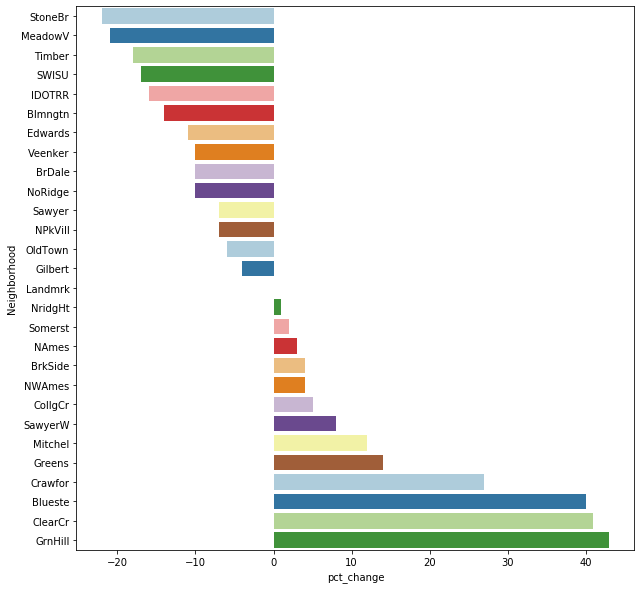

In [1115]:
# Bar plot to show different % change for different neighborhoods
fig, ax = plt.subplots(figsize= (10,10))
sns.barplot(x=price_pivot['pct_change'], y=price_pivot.index, palette="Paired", ax = ax)

Green hills is a retirement community   
Clear creek is right by a body of water/lake  
Bluestem is right next to iowa state university   

In [1120]:
# Average price by year sold to get % chane overall
price_year = df_train.groupby('Yr Sold').mean()[['SalePrice']]

In [1126]:
# House prices actually went down from the time span of 2006 - 2010
# Because of the housing market crash in 2008 
# Market had not recovered by 2010
# Change in house prices from 2006 to 2010

(price_year.iloc[4] - price_year.iloc[0])/price_year.iloc[0] * 100

SalePrice   -2.948405
dtype: float64

Text(0.5, 1.0, 'Number of Homes Sold by Year')

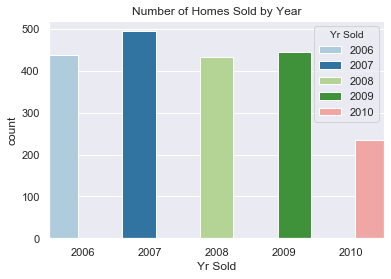

In [1245]:
# Bar chart of home sales year over year
sns.set(style="darkgrid")
fig, ax = plt.subplots()
sns.countplot(data = df_train, 
              x = 'Yr Sold',
              hue = 'Yr Sold', 
              palette = 'Paired',
             ax = ax)

# Code for changing bar width from: 
# https://stackoverflow.com/questions/34888058/changing-width-of-bars-in-bar-chart-created-using-seaborn-factorplot

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(ax, .5)
plt.title('Number of Homes Sold by Year')

In [1291]:
# Alphabetically order column names to make it easier to compare graphs
alpha_order = list(df_train['Neighborhood'].unique())
alpha_order.sort()
alpha_order

['Blmngtn',
 'Blueste',
 'BrDale',
 'BrkSide',
 'ClearCr',
 'CollgCr',
 'Crawfor',
 'Edwards',
 'Gilbert',
 'Greens',
 'GrnHill',
 'IDOTRR',
 'Landmrk',
 'MeadowV',
 'Mitchel',
 'NAmes',
 'NPkVill',
 'NWAmes',
 'NoRidge',
 'NridgHt',
 'OldTown',
 'SWISU',
 'Sawyer',
 'SawyerW',
 'Somerst',
 'StoneBr',
 'Timber',
 'Veenker']

Text(0.5, 1.0, 'Number of Homes Sold by Neighborhood by Year')

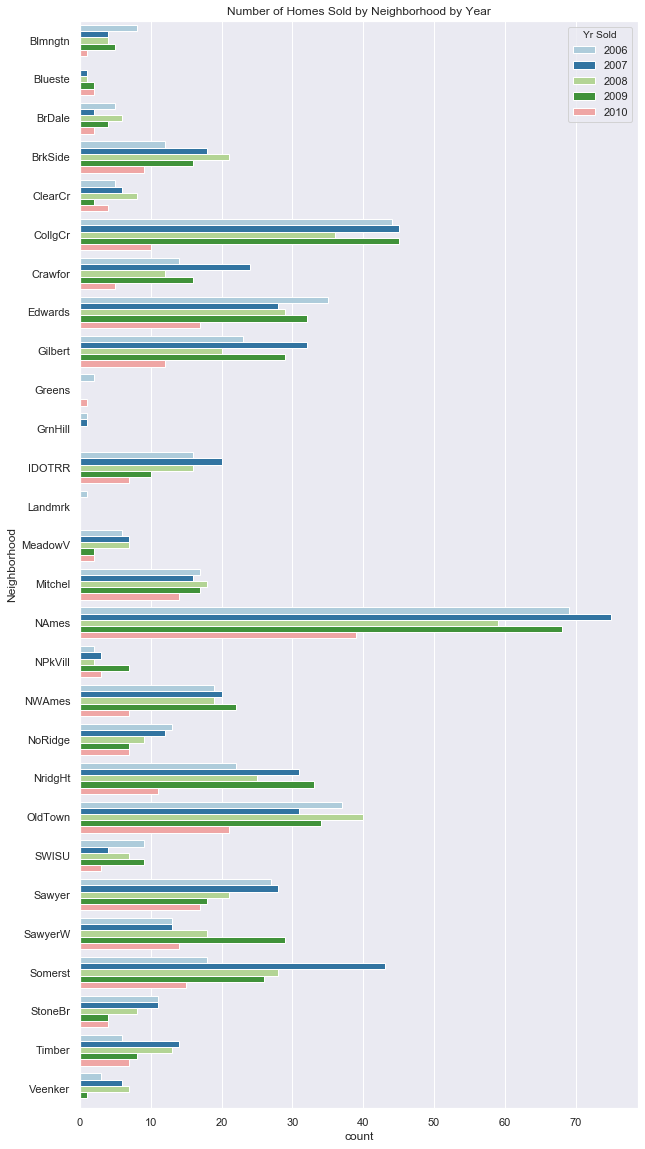

In [1292]:
# Plot the number of homes sold by neighborhood by year
fig,ax = plt.subplots(figsize = (10,20))
sns.countplot(data = df_train, 
              y = 'Neighborhood',
              hue = 'Yr Sold', 
              palette = 'Paired',
              order = alpha_order,
             ax = ax)

plt.title('Number of Homes Sold by Neighborhood by Year')

Text(0.5, 1.0, 'Number of Homes Sold by Neighborhood Overall')

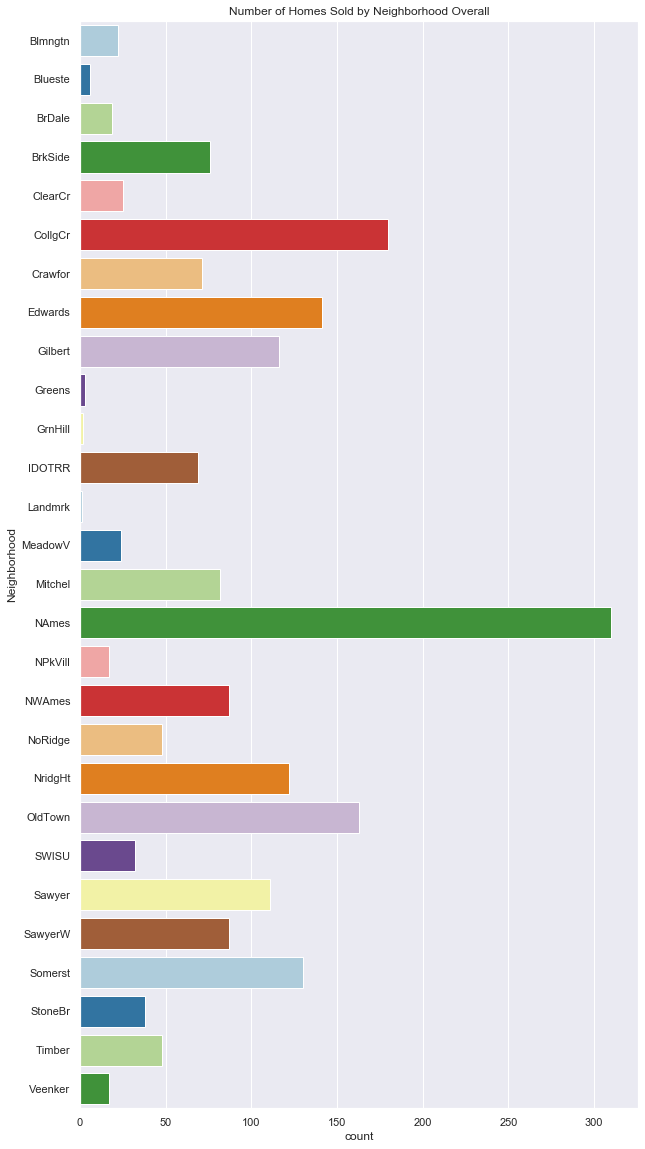

In [1293]:
# Plot the number of homes sold overall (2006-2010)
fig,ax = plt.subplots(figsize = (10,20))
sns.countplot(data = df_train, 
              y = 'Neighborhood', 
              palette = 'Paired',
              order = alpha_order,
             ax = ax)

plt.title('Number of Homes Sold by Neighborhood Overall')

In [1270]:
# Number of homes sold in each neighborhood in each year as a pivot table
# Will be used to compare change %

homes_by_hood = df_train.pivot_table(index = 'Neighborhood', columns = 'Yr Sold', values = 'PID', aggfunc = 'count')
homes_by_hood

Yr Sold       2006  2007  2008  2009  2010
Neighborhood                              
Blmngtn        8.0   4.0   4.0   5.0   1.0
Blueste        NaN   1.0   1.0   2.0   2.0
BrDale         5.0   2.0   6.0   4.0   2.0
BrkSide       12.0  18.0  21.0  16.0   9.0
ClearCr        5.0   6.0   8.0   2.0   4.0
CollgCr       44.0  45.0  36.0  45.0  10.0
Crawfor       14.0  24.0  12.0  16.0   5.0
Edwards       35.0  28.0  29.0  32.0  17.0
Gilbert       23.0  32.0  20.0  29.0  12.0
Greens         2.0   NaN   NaN   NaN   1.0
GrnHill        1.0   1.0   NaN   NaN   NaN
IDOTRR        16.0  20.0  16.0  10.0   7.0
Landmrk        1.0   NaN   NaN   NaN   NaN
MeadowV        6.0   7.0   7.0   2.0   2.0
Mitchel       17.0  16.0  18.0  17.0  14.0
NAmes         69.0  75.0  59.0  68.0  39.0
NPkVill        2.0   3.0   2.0   7.0   3.0
NWAmes        19.0  20.0  19.0  22.0   7.0
NoRidge       13.0  12.0   9.0   7.0   7.0
NridgHt       22.0  31.0  25.0  33.0  11.0
OldTown       37.0  31.0  40.0  34.0  21.0
SWISU          9.0   4.0   7.0   9.0   3.0
Sawyer        27.0  28.0  21.0  18.0  17.0
SawyerW       13.0  13.0  18.0  29.0  14.0
Somerst       18.0  43.0  28.0  26.0  15.0
StoneBr       11.0  11.0   8.0   4.0   4.0
Timber         6.0  14.0  13.0   8.0   7.0
Veenker        3.0   6.0   7.0   1.0   NaN

In [1210]:
# Most expensive and least expensive homes sold in which neighborhoods?
price_expensive = df_train['SalePrice'].quantile(q = .75)
# Use the 75th quantile as the baseline for 'expensive' home sale prices

In [1212]:
# New data frame to isolate just expensive homes
expensive_homes = df_train[df_train['SalePrice']> price_expensive]

Text(0.5, 1.0, 'Number of Expensive Homes Sold')

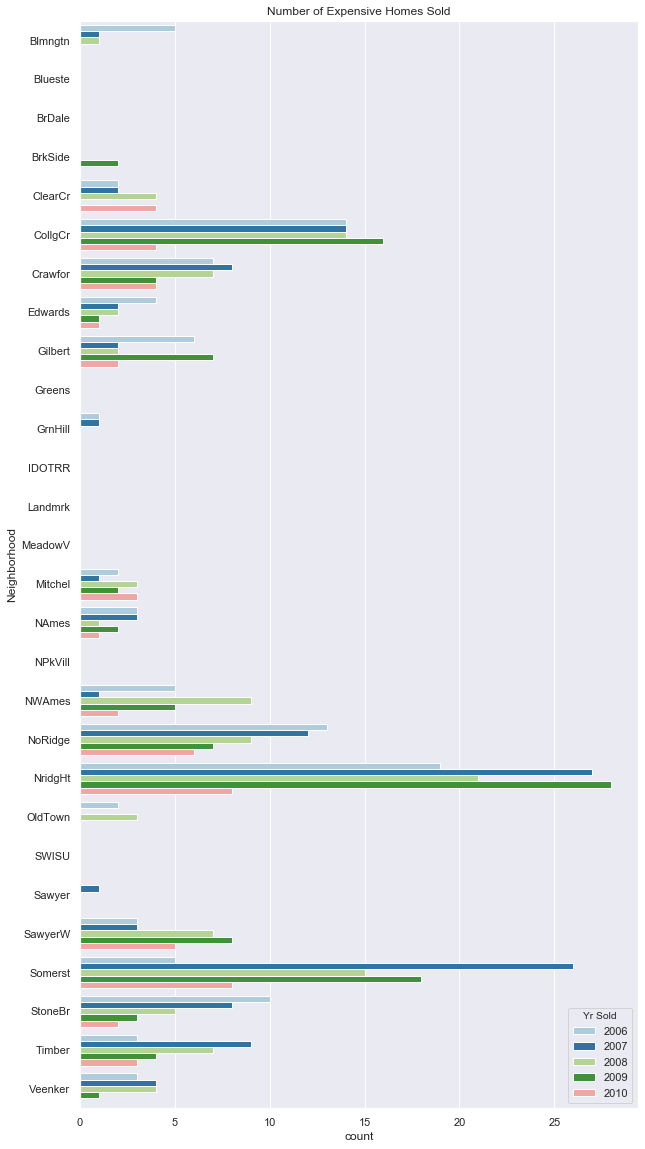

In [1295]:
# Plot number of expensive homes sold by neighborhood
fig,ax = plt.subplots(figsize = (10,20))
sns.countplot(data = expensive_homes, 
              y = 'Neighborhood',
              hue= 'Yr Sold',
              palette = 'Paired',
              order = alpha_order,
             ax = ax)

plt.title('Number of Expensive Homes Sold')

Text(0.5, 1.0, 'Number of Expensive Homes Sold Overall')

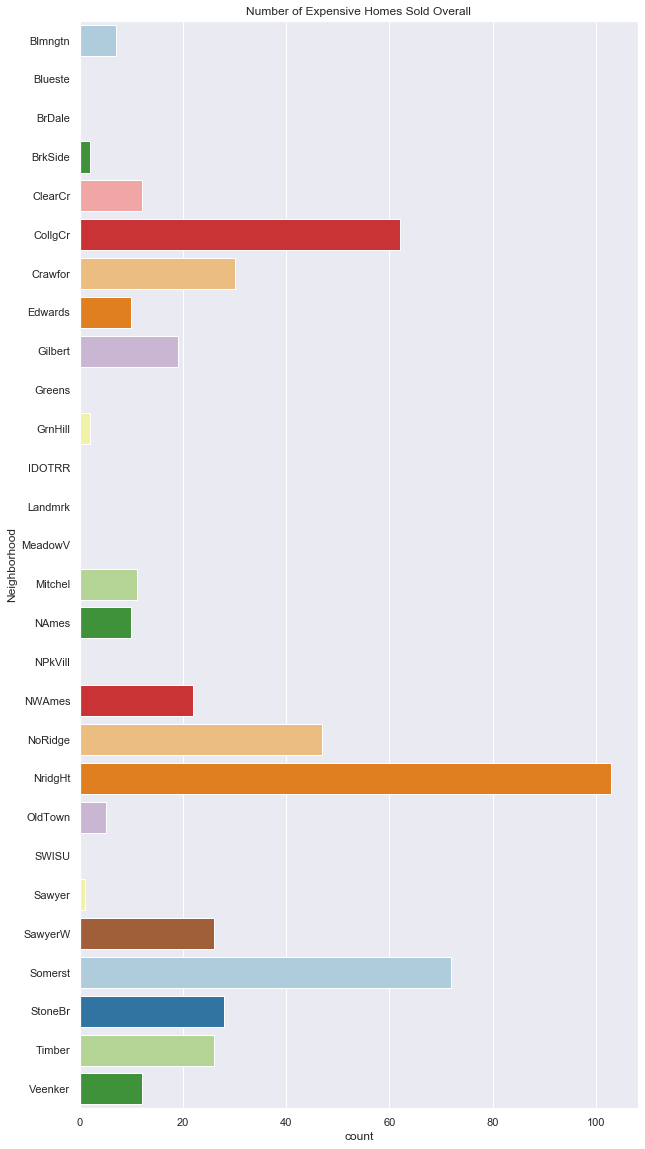

In [1296]:
# Number of expensive homes sold overall
fig,ax = plt.subplots(figsize = (10,20))
sns.countplot(data = expensive_homes, 
              y = 'Neighborhood',
              palette = 'Paired',
              order = alpha_order,
             ax = ax)

plt.title('Number of Expensive Homes Sold Overall')

In [1213]:
# Pivot table of expensive homes
expensive_homes.pivot_table(values = 'PID', index = 'Neighborhood', columns = 'Yr Sold', aggfunc = 'count')

Yr Sold       2006  2007  2008  2009  2010
Neighborhood                              
Blmngtn        5.0   1.0   1.0   NaN   NaN
BrkSide        NaN   NaN   NaN   2.0   NaN
ClearCr        2.0   2.0   4.0   NaN   4.0
CollgCr       14.0  14.0  14.0  16.0   4.0
Crawfor        7.0   8.0   7.0   4.0   4.0
Edwards        4.0   2.0   2.0   1.0   1.0
Gilbert        6.0   2.0   2.0   7.0   2.0
GrnHill        1.0   1.0   NaN   NaN   NaN
Mitchel        2.0   1.0   3.0   2.0   3.0
NAmes          3.0   3.0   1.0   2.0   1.0
NWAmes         5.0   1.0   9.0   5.0   2.0
NoRidge       13.0  12.0   9.0   7.0   6.0
NridgHt       19.0  27.0  21.0  28.0   8.0
OldTown        2.0   NaN   3.0   NaN   NaN
Sawyer         NaN   1.0   NaN   NaN   NaN
SawyerW        3.0   3.0   7.0   8.0   5.0
Somerst        5.0  26.0  15.0  18.0   8.0
StoneBr       10.0   8.0   5.0   3.0   2.0
Timber         3.0   9.0   7.0   4.0   3.0
Veenker        3.0   4.0   4.0   1.0   NaN

In [1497]:
# Pivot table of cheap homes
price_cheap = df_train['SalePrice'].quantile(q = .25)
cheap_homes = df_train[df_train['SalePrice'] < price_cheap]
cheap_homes.pivot_table(values = 'PID', index = 'Neighborhood', columns = 'Yr Sold', aggfunc = 'count')

Yr Sold       2006  2007  2008  2009  2010
Neighborhood                              
Blueste        NaN   1.0   NaN   2.0   NaN
BrDale         5.0   2.0   6.0   4.0   2.0
BrkSide        9.0  10.0  14.0   6.0   5.0
CollgCr        1.0   6.0   1.0   1.0   1.0
Crawfor        NaN   2.0   NaN   NaN   NaN
Edwards       19.0  16.0  18.0  22.0  12.0
IDOTRR        15.0  11.0  14.0   7.0   7.0
MeadowV        5.0   5.0   7.0   2.0   2.0
Mitchel        2.0   3.0   3.0   1.0   NaN
NAmes         15.0  26.0  14.0  24.0  10.0
NPkVill        NaN   1.0   NaN   1.0   2.0
NWAmes         NaN   1.0   NaN   1.0   NaN
OldTown       26.0  17.0  25.0  25.0  12.0
SWISU          4.0   2.0   2.0   2.0   3.0
Sawyer         8.0  12.0   6.0   8.0   8.0
SawyerW        1.0   1.0   NaN   5.0   1.0

Text(0.5, 1.0, 'Number of Cheap Homes Sold')

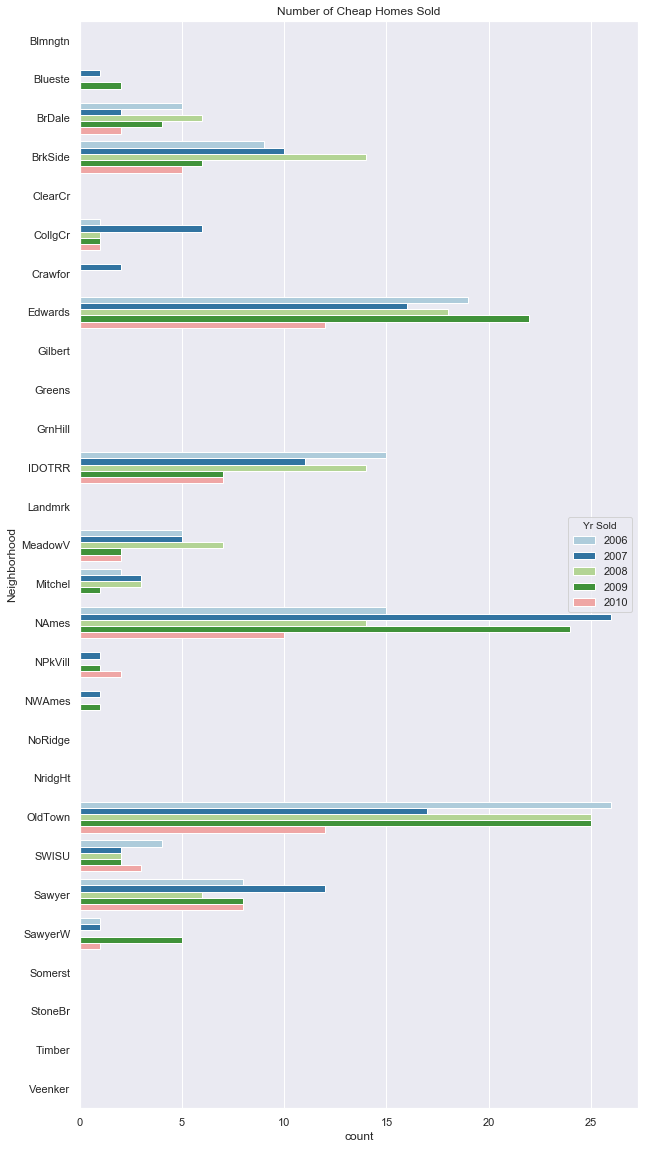

In [1498]:
# Plot the number of cheap homes sold by neighborhood
fig,ax = plt.subplots(figsize = (10,20))
sns.countplot(data = cheap_homes, 
              y = 'Neighborhood',
              hue = 'Yr Sold',
              palette = 'Paired',
              order = alpha_order,
             ax = ax)

plt.title('Number of Cheap Homes Sold')

Text(0.5, 1.0, 'Number of Cheap Homes Sold')

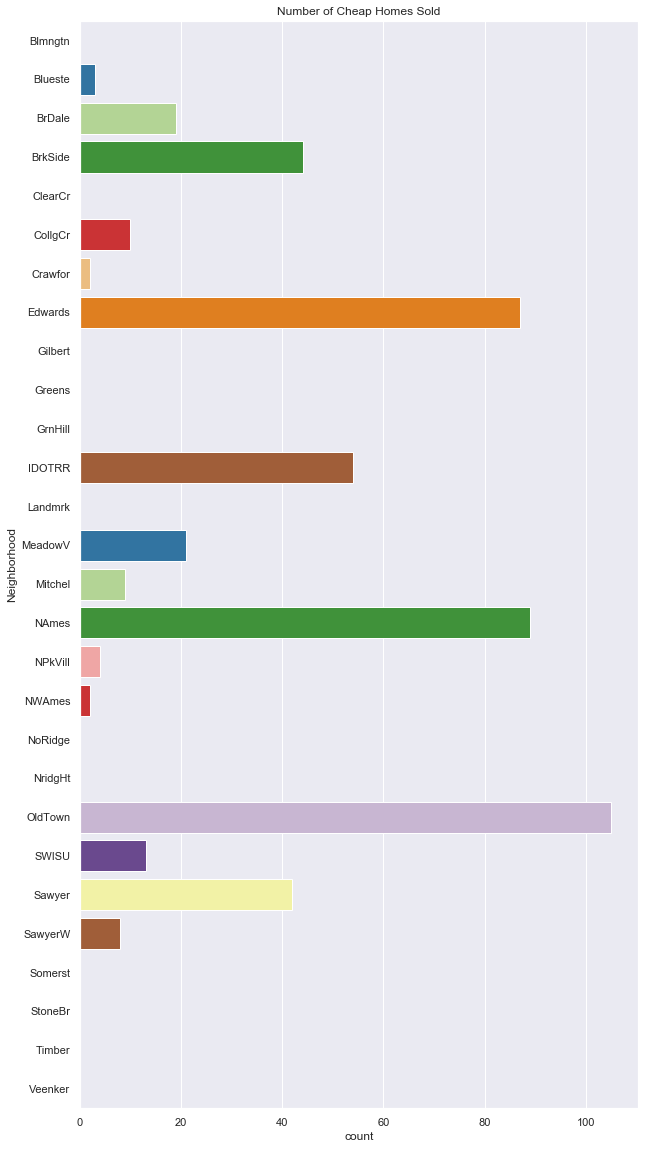

In [1499]:
# Number of cheap homes sold overall
fig,ax = plt.subplots(figsize = (10,20))
sns.countplot(data = cheap_homes, 
              y = 'Neighborhood',
              palette = 'Paired',
              order = alpha_order,
             ax = ax)

plt.title('Number of Cheap Homes Sold')

In [1500]:
# Create a total homes dataframe, grouped by neighborhood
homes_sales_df = expensive_homes.groupby('Neighborhood').count()[['PID']]
homes_sales_df['total']=df_train.groupby('Neighborhood').count()['PID']
homes_sales_df['cheap'] = cheap_homes.groupby('Neighborhood').count()['PID']
homes_sales_df

PID  total  cheap
Neighborhood                   
Blmngtn         7     22    NaN
BrkSide         2     76   44.0
ClearCr        12     25    NaN
CollgCr        62    180   10.0
Crawfor        30     71    2.0
Edwards        10    141   87.0
Gilbert        19    116    NaN
GrnHill         2      2    NaN
Mitchel        11     82    9.0
NAmes          10    310   89.0
NWAmes         22     87    2.0
NoRidge        47     48    NaN
NridgHt       103    122    NaN
OldTown         5    163  105.0
Sawyer          1    111   42.0
SawyerW        26     87    8.0
Somerst        72    130    NaN
StoneBr        28     38    NaN
Timber         26     48    NaN
Veenker        12     17    NaN

In [1501]:
# % of each home type for neighborhood
homes_sales_df['pct_exp'] = np.round((homes_sales_df['PID']/homes_sales_df['total'])*100,2)
homes_sales_df['pct_cheap'] = np.round((homes_sales_df['cheap']/homes_sales_df['total'])*100,2)

In [1503]:
# Number of homes remodeled
homes_sales_df['remod_count'] = df_train[df_train['Year Built'] != df_train['Year Remod/Add']].groupby('Neighborhood').count()['Year Remod/Add']




In [1504]:
# % of homes remodeled
homes_sales_df['pct_remod'] = np.round(homes_sales_df['remod_count'] / homes_sales_df['total']*100,2)

In [1505]:
# % of total home sales
homes_sales_df['pct_total'] = np.round((homes_sales_df['total']/homes_sales_df['total'].sum())*100,2)

In [1506]:
homes_sales_df

PID  total  cheap  pct_exp  pct_cheap  remod_count  pct_remod  \
Neighborhood                                                                  
Blmngtn         7     22    NaN    31.82        NaN         10.0      45.45   
BrkSide         2     76   44.0     2.63      57.89         74.0      97.37   
ClearCr        12     25    NaN    48.00        NaN         14.0      56.00   
CollgCr        62    180   10.0    34.44       5.56         53.0      29.44   
Crawfor        30     71    2.0    42.25       2.82         61.0      85.92   
Edwards        10    141   87.0     7.09      61.70         78.0      55.32   
Gilbert        19    116    NaN    16.38        NaN         39.0      33.62   
GrnHill         2      2    NaN   100.00        NaN          NaN        NaN   
Mitchel        11     82    9.0    13.41      10.98         28.0      34.15   
NAmes          10    310   89.0     3.23      28.71         95.0      30.65   
NWAmes         22     87    2.0    25.29       2.30         25.0      28.74   
NoRidge        47     48    NaN    97.92        NaN         21.0      43.75   
NridgHt       103    122    NaN    84.43        NaN         54.0      44.26   
OldTown         5    163  105.0     3.07      64.42        147.0      90.18   
Sawyer          1    111   42.0     0.90      37.84         43.0      38.74   
SawyerW        26     87    8.0    29.89       9.20         31.0      35.63   
Somerst        72    130    NaN    55.38        NaN         41.0      31.54   
StoneBr        28     38    NaN    73.68        NaN         10.0      26.32   
Timber         26     48    NaN    54.17        NaN         23.0      47.92   
Veenker        12     17    NaN    70.59        NaN          6.0      35.29   

              pct_total  
Neighborhood             
Blmngtn            1.17  
BrkSide            4.05  
ClearCr            1.33  
CollgCr            9.59  
Crawfor            3.78  
Edwards            7.52  
Gilbert            6.18  
GrnHill            0.11  
Mitchel            4.37  
NAmes             16.52  
NWAmes             4.64  
NoRidge            2.56  
NridgHt            6.50  
OldTown            8.69  
Sawyer             5.92  
SawyerW            4.64  
Somerst            6.93  
StoneBr            2.03  
Timber             2.56  
Veenker            0.91

In [1507]:
# % change in price
homes_sales_df['pct_change_price'] = price_pivot['pct_change']

In [1508]:
homes_sales_df.sort_values('pct_total', ascending = False)

PID  total  cheap  pct_exp  pct_cheap  remod_count  pct_remod  \
Neighborhood                                                                  
NAmes          10    310   89.0     3.23      28.71         95.0      30.65   
CollgCr        62    180   10.0    34.44       5.56         53.0      29.44   
OldTown         5    163  105.0     3.07      64.42        147.0      90.18   
Edwards        10    141   87.0     7.09      61.70         78.0      55.32   
Somerst        72    130    NaN    55.38        NaN         41.0      31.54   
NridgHt       103    122    NaN    84.43        NaN         54.0      44.26   
Gilbert        19    116    NaN    16.38        NaN         39.0      33.62   
Sawyer          1    111   42.0     0.90      37.84         43.0      38.74   
SawyerW        26     87    8.0    29.89       9.20         31.0      35.63   
NWAmes         22     87    2.0    25.29       2.30         25.0      28.74   
Mitchel        11     82    9.0    13.41      10.98         28.0      34.15   
BrkSide         2     76   44.0     2.63      57.89         74.0      97.37   
Crawfor        30     71    2.0    42.25       2.82         61.0      85.92   
NoRidge        47     48    NaN    97.92        NaN         21.0      43.75   
Timber         26     48    NaN    54.17        NaN         23.0      47.92   
StoneBr        28     38    NaN    73.68        NaN         10.0      26.32   
ClearCr        12     25    NaN    48.00        NaN         14.0      56.00   
Blmngtn         7     22    NaN    31.82        NaN         10.0      45.45   
Veenker        12     17    NaN    70.59        NaN          6.0      35.29   
GrnHill         2      2    NaN   100.00        NaN          NaN        NaN   

              pct_total  pct_change_price  
Neighborhood                               
NAmes             16.52               3.0  
CollgCr            9.59               5.0  
OldTown            8.69              -6.0  
Edwards            7.52             -11.0  
Somerst            6.93               2.0  
NridgHt            6.50               1.0  
Gilbert            6.18              -4.0  
Sawyer             5.92              -7.0  
SawyerW            4.64               8.0  
NWAmes             4.64               4.0  
Mitchel            4.37              12.0  
BrkSide            4.05               4.0  
Crawfor            3.78              27.0  
NoRidge            2.56             -10.0  
Timber             2.56             -18.0  
StoneBr            2.03             -22.0  
ClearCr            1.33              41.0  
Blmngtn            1.17             -14.0  
Veenker            0.91             -10.0  
GrnHill            0.11              43.0

In [1358]:
# Number of homes sold by year, in order to calculate % drop in total home sales 
# -48% drop in home sales from 2009-2010
df_train.groupby('Yr Sold').count()['PID']

Yr Sold
2006    438
2007    495
2008    434
2009    446
2010    234
Name: PID, dtype: int64

## Conclusion and Recommendations

Based on the analysis in part 2 of the EDA, it can be noted that while certain neighborhoods have benefits, they also come with their own negatives. For cheaper neighborhoods, while their remodeling rate was much higher than those of expensive ones, there is also the risk of being unable to gain a large ROI as all the other homes in the area are priced lower. With the expensive neighborhood, you run the risk of not being able to remodel enough to get a greater ROI. Also, as home prices in that area are more expensive, the price tag might make it harder to sell as quickly as possible. 

Given all of this information, it will be useful to look into each neighborhood and change specific qualities of homes to see its predicted price. The model will be useful for being able to estimate house prices from a one unit change in certain features. It can estimate the ROI and isolate which houses have the most potential for remodeling. 

While the model incorporates many features, the data is still lacking in certain aspects. It would have been incredibly useful to have macroeconomic details. There is no information about the housing market crisis incorporated into this data set. Also, this model can only be utilized in terms of Ames. As quality is subjective, it can only work for the Ames home market. It would also be beneficial to have information on how remodeling effected home sale prices. The value of the house pre and post remodeling would be beneficial to see the magnitude of changing one feature over another.